In [135]:
import json
import os
import sys
import importlib
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
import src.plots

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import dateutil

plt.style.use('../data/metadata/Nilerat_matplotlib_stylesheet.mplstyle')

In [225]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

# Connected dots plot

## Group data within-animal and sampling

## Take RSD of each 3-week repeated measurement for each metabolite within each animal within each sampling type

## find mean of these RSDs for connected dot plot

In [297]:
fdf.shape

(49, 4)

In [294]:
rbgs = [f'RBGweek{x}' for x in range(8, 13)]
fbgs = [f'FBGweek{x}' for x in range(8, 13)]

bgs = ap.loc[ap['original'], rbgs + fbgs]
bgs['animal'] = bgs.index
bgs['Nile rat label'] = bgs['animal'].map(ap['Nile rat label'])
bgs['rmean'] = bgs[rbgs].mean(axis=1)
bgs['fmean'] = bgs[fbgs].mean(axis=1)
bgs['rrsd'] = (bgs[rbgs].std(axis=1) / bgs['rmean']) * 100
bgs['frsd'] = (bgs[fbgs].std(axis=1) / bgs['fmean']) * 100
bgs = bgs.sort_values('Nile rat label')

mbgs = bgs.melt(id_vars=['animal', 'Nile rat label', 'rmean', 'fmean'], 
                value_vars=rbgs+fbgs, value_name='BG', var_name='week')
mbgs['bg_type'] = mbgs['week'].str[:3]
mbgs['week'] = mbgs['week'].str[7:].astype('int')
mbgs['rdiff'] = mbgs['BG'] - mbgs['rmean']
mbgs['fdiff'] = mbgs['BG'] - mbgs['fmean']
mbgs['r%'] = mbgs['rdiff'] / mbgs['BG'] * 100
mbgs['f%'] = mbgs['fdiff'] / mbgs['BG'] * 100
mbgs = mbgs.sort_values('Nile rat label')
mbgs = mbgs.loc[~(mbgs['f%'] < -100) | ~(mbgs['r%'] < -100)]

label_order = [x for x in 'ABCDEFGHIJ']
animal_order = mbgs['animal'].unique()
rdf = mbgs.loc[(mbgs['bg_type'] == 'RBG') & (mbgs['r%'] > -100), ['r%', 'animal', 'week', 'Nile rat label']]
fdf = mbgs.loc[(mbgs['bg_type'] == 'FBG') & (mbgs['f%'] > -100), ['f%', 'animal', 'week', 'Nile rat label']]


In [139]:
gb = np.power(2, data.loc[:, data_cols])
gb = (gb
 .T
 .join(fg[['animal', 'bg_type']])
 .groupby(['animal', 'bg_type'])
)
gb = (gb.std() / gb.mean()) * 100
# display(gb)

per_animal = (gb
    .median(axis=1)
    .reset_index()
    )
per_animal['bg_type'] = per_animal['bg_type'].map({'RBG': 'Non-fasted', 'FBG': 'Fasted'})
per_animal = per_animal.rename({0: '% RSD'}, axis=1)
per_animal['animal'] = per_animal['animal'].astype('int')
per_animal['Nile rat label'] = per_animal['animal'].map(ap['Nile rat label'])
per_animal = per_animal.sort_values('Nile rat label')
loc_dict = {x: i for x, i in zip('ABCDEFGHIJ', range(10))}
per_animal['loc'] = per_animal['Nile rat label'].map(loc_dict)
display(per_animal)

superclass_type_dict = dict(zip(data['superclass'], data['Type']))
per_class = (gb
            .groupby(data['molec_class'], axis=1)
            .median()
            .groupby(level=['bg_type'])
            .median()
            .melt(ignore_index=False, value_name='% RSD')
            .reset_index()
            .assign(superclass=lambda x: x['molec_class'].map(compound_superclasses))
            .assign(Type=lambda x: x['superclass'].map(superclass_type_dict))
            .sort_values(['Type', '% RSD', 'bg_type'], ascending=[True, True, False])
            )
# display(per_class)
per_class = per_class.loc[per_class['molec_class'] != 'Unidentified']
per_class['bg_type'] = per_class['bg_type'].map({'RBG': 'Non-fasted', 'FBG': 'Fasted'})
loc_dict = {x: i for x, i in zip(per_class['molec_class'].unique(), range(len(per_class['molec_class'].unique())))}
per_class['loc'] = per_class['molec_class'].map(loc_dict)
display(per_class)

violin_data = gb.melt(var_name='i', ignore_index=False).reset_index()
violin_data['Nile rat label'] = violin_data['animal'].map(ap['Nile rat label'])
violin_data['bg_type'] = violin_data['bg_type'].map({'RBG': 'Non-fasted', 'FBG': 'Fasted'})
violin_data = violin_data.sort_values('Nile rat label')
violin_data = violin_data.join(data['molec_class'], on='i')
display(violin_data)

ddf = pd.read_excel('../data/metadata/12hour RBGs.xlsx', index_col=0)
ddf.index = [x[1:] for x in ddf.index]
ddf['animal'] = ddf.index
time_order = ddf.filter(regex='^\d').columns
ddf['median'] = ddf[time_order].median(axis=1)
ddf['mean'] = ddf[time_order].mean(axis=1)
ddf['mean_rank'] = ddf['mean'].rank()
ddf['% RSD'] = ddf[time_order].std(axis=1)/ddf['mean'] * 100
mddf = ddf.melt(id_vars=['sex', 'animal', 'mean', 'mean_rank'], value_vars=time_order, value_name='RBG', var_name='Time')
# mddf.index = mddf['animal']
mddf['mean_diff'] = mddf['RBG'] - mddf['mean']
mddf['mean_%_diff'] = mddf['mean_diff'] / mddf['mean'] * 100
display(ddf)
display(mddf)
rbg_order = ddf.sort_values('mean').index
sex_order = ddf.sort_values(['sex', 'mean']).index

,animal,bg_type,% RSD,Nile rat label,loc
10,1091,Fasted,19.298730,A,0
11,1091,Non-fasted,27.730305,A,0
15,1093,Non-fasted,23.947800,B,1
14,1093,Fasted,20.359515,B,1
13,1092,Non-fasted,25.302882,C,2
12,1092,Fasted,21.187946,C,2
4,1074,Fasted,28.095956,D,3
5,1074,Non-fasted,21.367378,D,3
2,1062,Fasted,26.863007,E,4
3,1062,Non-fasted,20.490741,E,4


,bg_type,molec_class,% RSD,superclass,Type,loc
4,Fasted,Alkenyl-DG,12.554947,Glycerolipid,lipid,0
5,Non-fasted,Alkenyl-DG,12.904959,Glycerolipid,lipid,0
0,Fasted,AC,15.491588,Fatty Acyl,lipid,1
1,Non-fasted,AC,15.838062,Fatty Acyl,lipid,1
31,Non-fasted,PI,16.294640,Phospholipid,lipid,2
41,Non-fasted,SM,16.425895,Sphingolipid,lipid,3
40,Fasted,SM,16.911088,Sphingolipid,lipid,3
35,Non-fasted,Plasmanyl-PE,16.915532,Phospholipid,lipid,4
10,Fasted,CE,17.185587,Sterol Lipid,lipid,5
27,Non-fasted,PC,17.212549,Phospholipid,lipid,6


,animal,bg_type,i,value,Nile rat label,molec_class
0,1060,Fasted,m_0,135.033146,NaN,Unidentified
1,1060,Non-fasted,m_0,109.122505,NaN,Unidentified
2,1062,Fasted,m_0,42.979048,NaN,Unidentified
3,1062,Non-fasted,m_0,19.083103,NaN,Unidentified
4,1074,Fasted,m_0,41.796211,NaN,Unidentified
...,...,...,...,...,...,...
28175,1093,Non-fasted,l_916,38.184628,NaN,Unidentified
28176,1101,Fasted,l_916,43.266060,NaN,Unidentified
28177,1101,Non-fasted,l_916,34.610618,NaN,Unidentified
28178,1102,Fasted,l_916,32.240494,NaN,Unidentified


,sex,10am,11am,12pm,1pm,2pm,3pm,4pm,5pm,6pm,...,8pm,9pm,10pm,weight 10am,weight 10pm,animal,median,mean,mean_rank,% RSD
1772F,F,296.666667,290.000000,350.5,281.500000,288.500000,351.5,295.500000,350.5,253.5,...,252.5,268.333333,218.500000,111.6,110.2,1772F,288.500000,291.153846,12.0,13.867024
1771F,F,258.500000,192.500000,210.0,178.000000,171.000000,148.5,154.000000,201.0,213.5,...,243.0,193.333333,216.000000,127.9,127.8,1771F,201.000000,203.141026,4.0,17.782218
1767M,M,291.666667,252.000000,155.0,145.000000,165.000000,184.0,258.000000,229.0,248.5,...,220.5,220.500000,226.000000,122.6,120.5,1767M,226.000000,217.551282,5.0,20.034393
1735M,M,338.500000,242.500000,277.0,263.000000,284.500000,307.5,292.000000,260.5,272.5,...,257.0,288.000000,281.500000,124.0,122.8,1735M,277.000000,278.769231,11.0,8.955611
1748F,F,93.000000,80.000000,110.0,156.000000,99.000000,103.0,78.500000,116.5,95.0,...,75.0,99.500000,82.000000,125.8,126.0,1748F,99.000000,101.076923,1.0,22.289428
1792M,M,302.500000,296.500000,367.5,311.500000,312.500000,335.0,276.000000,291.0,306.0,...,269.0,308.500000,327.500000,130.5,120.5,1792M,306.000000,306.230769,13.0,8.727893
1768M,M,334.000000,230.000000,270.0,264.000000,286.500000,244.0,177.000000,210.0,288.0,...,223.5,246.500000,197.500000,129.2,128.2,1768M,244.000000,246.807692,7.0,17.065372
1757M,M,254.000000,262.000000,243.5,266.333333,253.000000,237.5,263.000000,275.0,278.0,...,278.0,361.000000,361.333333,127.7,125.2,1757M,266.333333,277.128205,10.0,14.185483
1680M,M,357.500000,257.000000,251.0,227.000000,211.666667,235.5,207.000000,270.5,253.0,...,276.5,209.000000,248.000000,120.5,120.9,1680M,248.000000,246.935897,8.0,16.635832
1669F,F,214.000000,128.666667,224.0,193.500000,227.500000,231.0,179.666667,162.5,156.5,...,193.0,241.500000,171.500000,122.2,121.4,1669F,193.000000,192.333333,3.0,17.555058


,sex,animal,mean,mean_rank,Time,RBG,mean_diff,mean_%_diff
0,F,1772F,291.153846,12.0,10am,296.666667,5.512821,1.893439
1,F,1771F,203.141026,4.0,10am,258.500000,55.358974,27.251499
2,M,1767M,217.551282,5.0,10am,291.666667,74.115385,34.068006
3,M,1735M,278.769231,11.0,10am,338.500000,59.730769,21.426600
4,F,1748F,101.076923,1.0,10am,93.000000,-8.076923,-7.990868
...,...,...,...,...,...,...,...,...
164,M,1680M,246.935897,8.0,10pm,248.000000,1.064103,0.430923
165,F,1669F,192.333333,3.0,10pm,171.500000,-20.833333,-10.831889
166,M,1666M,250.576923,9.0,10pm,235.500000,-15.076923,-6.016884
167,F,1664F,109.134615,2.0,10pm,103.000000,-6.134615,-5.621145


## Calculate within-animal RSD for all lipids (ID and un-ID) to compare to Figure 7B

## Supplemental figure

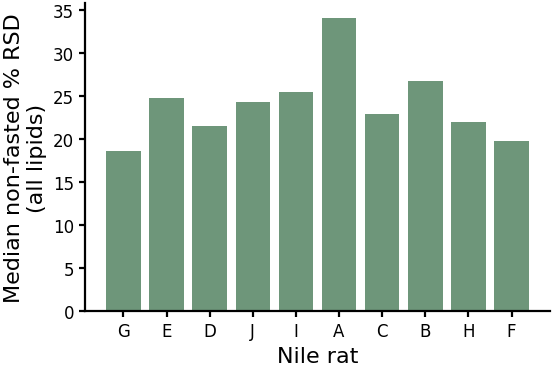

In [332]:
fig, ax = plt.subplots(dpi=200, figsize=(3, 2))
all_lipids_per_animal = gb.loc[
    gb.index.get_level_values('bg_type') == 'RBG', 
    data.loc[data['Type']=='lipid'].index
]
ogtt_order = ap.loc[ap['original']].sort_values('Nile rat label').index
lip_meds = all_lipids_per_animal.median(axis=1)
ax.bar(range(10), lip_meds, color=colors['M'], alpha=0.8)
ax.set_xticks(
    range(10), 
    lip_meds.index.get_level_values('animal').astype('int').map(ap['Nile rat label'])
)
ax.set_xlabel('Nile rat')
ax.set_ylabel('Median non-fasted % RSD\n(all lipids)')
sns.despine()
plt.savefig('../reports/figures/FigureSupp/10wk_lipids_RSD.pdf', bbox_inches='tight', dpi=300)
plt.savefig('../reports/figures/FigureSupp/10wk_lipids_RSD.png', bbox_inches='tight', dpi=300)

In [339]:
cdf = pd.DataFrame(colors).T
cdf['RBG'] = cdf[0].round(4).astype(str) + ', ' + cdf[1].astype(str) + ', ' + cdf[2].astype(str)
cdf

,0,1,2,RBG
lipid,0.400000,0.760784,0.647059,"0.4, 0.7607843137254902, 0.6470588235294118"
metabolite,0.988235,0.552941,0.384314,"0.9882, 0.5529411764705883, 0.3843137254901961"
Glycerolipid,0.687500,0.476562,0.632812,"0.6875, 0.4765625, 0.6328125"
Sterol Lipid,0.304688,0.472656,0.652344,"0.3047, 0.47265625, 0.65234375"
Sphingolipid,0.945312,0.554688,0.167969,"0.9453, 0.5546875, 0.16796875"
...,...,...,...,...
E,0.143343,0.522773,0.556295,"0.1433, 0.522773, 0.556295"
G,0.166383,0.690856,0.496502,"0.1664, 0.690856, 0.496502"
H,0.319809,0.770914,0.411152,"0.3198, 0.770914, 0.411152"
I,0.525776,0.833491,0.288127,"0.5258, 0.833491, 0.288127"


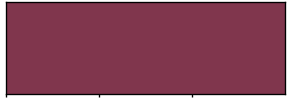

In [346]:
sns.palplot(plt.matplotlib.colors.to_rgb('#80364d'))

In [353]:
seen = set()
cold = {}
for name, color in colors.items():
    hex_ = plt.matplotlib.colors.to_hex(color)
    if hex_ in seen:
        continue
    seen.add(hex_)
    print(name, hex_)
    cold[name] = hex_
pd.Series(cold).to_csv('../data/metadata/Nile_rat_colors.csv')

lipid #66c2a5
metabolite #fc8d62
Glycerolipid #af7aa1
Sterol Lipid #4e79a6
Sphingolipid #f18d2b
Phospholipid #59a04e
Fatty Acyl #e05759
Unidentified #b9afab
Organic acid #e5c494
Carbohydrate #8da0cb
Amino acid derivative #e78ac3
Alcohol #a6d854
M #4a7c59
F #1e9b8a
Female #80364d
FBG #c17a53
RBG #6b6d8b
normal #029e73
impaired #cc78bc
diabetic #d55e00
1091 #482173
1093 #433e85
1092 #38588c
1074 #2d708e
1062 #25858e
1060 #2ab07f
1101 #52c569
1082 #86d549
1076 #c2df23


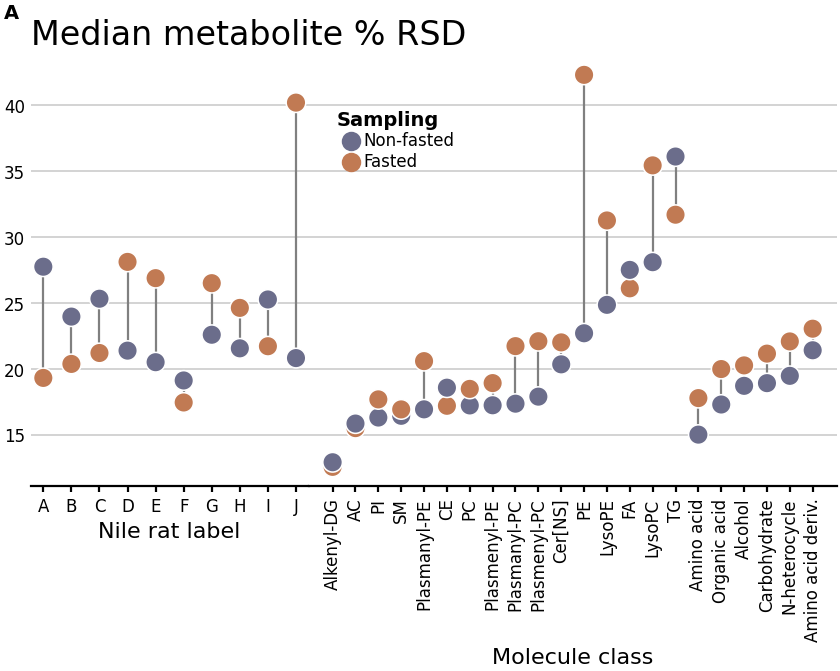

In [299]:
importlib.reload(src.plots)
fig, (ax1, ax2) = plt.subplots(
    dpi=200, figsize=(5.2, 2.8), 
    ncols=2, gridspec_kw=dict(width_ratios=[1, 1.9], wspace=0), sharey=True,
)




hue_order = ['Non-fasted', 'Fasted', ]
s = 50
sns.scatterplot(
    data=per_animal, x='Nile rat label', y='% RSD', hue='bg_type', hue_order=hue_order, palette=colors, ax=ax1,
    linewidths=0, edgecolors='none', zorder=2, s=s, legend=False,
)

sns.scatterplot(
    data=per_class, x='molec_class', y='% RSD', hue='bg_type', hue_order=hue_order, palette=colors, ax=ax2,
    linewidths=0, edgecolors='none', legend=True, zorder=2, s=s,
)

for ax, df in [(ax1, per_animal), (ax2, per_class)]:
    for loc in df['loc'].unique():
        sdf = df.loc[df['loc'] == loc]
#         display(sdf)
        fasted_rsd =    sdf.loc[sdf['bg_type'] == 'Fasted', '% RSD'].values[0]
        nonfasted_rsd = sdf.loc[sdf['bg_type'] == 'Non-fasted', '% RSD'].values[0]
        ax.plot([loc, loc], [fasted_rsd, nonfasted_rsd], color='gray', lw=0.8, zorder=1,)
    
classes = per_class['molec_class'].unique()
classes[-1] = 'Amino acid deriv.'
classes[-2] = 'N-heterocycle'
ax2.set_xticks(ticks=range(len(classes)), labels=classes)
ax2.tick_params(rotation=90)
ax2.tick_params(axis='y', length=0)
ax2.set_xlabel('Molecule class')
ax1.tick_params(axis='y', length=0)
ax1.set_ylabel(None)
ax1.set_title('Median metabolite % RSD', loc='left')
        
for ax in (ax1, ax2):
    ax.grid(axis='y', color=src.plots.GRID_LIGHT_COLOR, lw=src.plots.GRID_LW)
    ax.set_axisbelow(True)

legend = ax2.legend(
    loc=(0.05, 0.73),     
    title='Sampling', fontsize=src.plots.LEGEND_TEXT_FONTSIZE, 
    title_fontproperties=dict(size=src.plots.LEGEND_TITLE_FONTSIZE, weight='bold'),
    handletextpad=-0.1, labelspacing=0.15, borderaxespad=0, handlelength=1.7,
    borderpad=0.1, markerscale=1.,
#           frameon=True, framealpha=1, facecolor='1', fancybox=False, edgecolor='none'
#     zorder=10,
    )
legend._legend_box.align = 'left'  # shift legend title to left alignment

bb = src.plots.tight_bbox(ax1)
ax1.text(x=bb.x0, y=bb.y1, s='A', fontsize=src.plots.LABEL_FONTSIZE, transform=fig.transFigure, fontweight='bold')
    
sns.despine(ax=ax1, left=True)
sns.despine(ax=ax2, left=True)
# plt.savefig('../reports/figures/Figure3/RSDs_vertical.pdf', dpi=300, bbox_inches='tight')

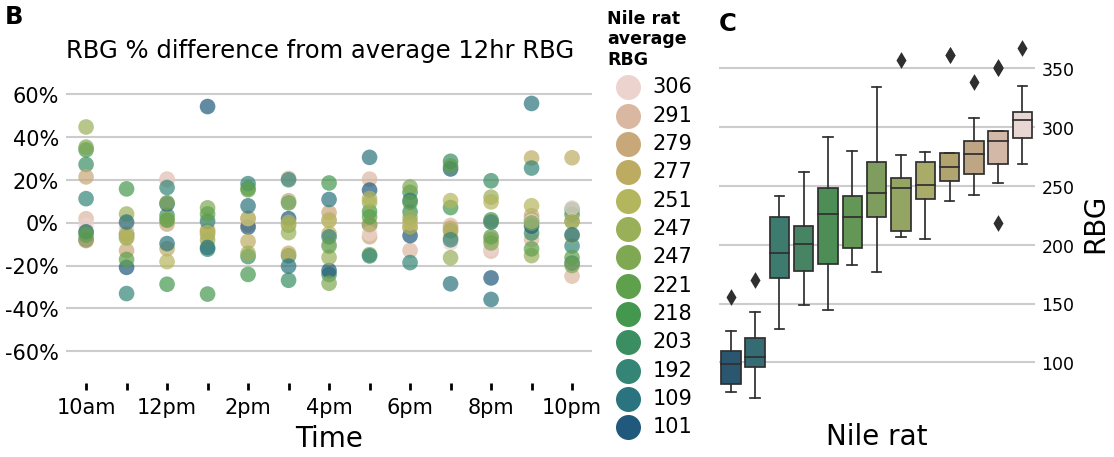

In [157]:
importlib.reload(src.plots)
fig, axs = plt.subplot_mosaic(
    """
    .C
    BC
    .C
    """,
    dpi=250, figsize=(5, 2), gridspec_kw=dict(width_ratios=[1, 0.6], wspace=0.3,
                                              height_ratios=[0.1, 1, 0.1], hspace=0,),
)
ax, ax2 = axs['B'], axs['C']

palette = 'gist_earth'  # crest  flare  gist_earth PuBuGn viridis cividis
palette = sns.color_palette('gist_earth', 15)[2:]
sns.stripplot(
# sns.boxplot(
    data=mddf, x='Time', y='mean_%_diff', ax=ax, 
#     dodge=False,
    jitter=False, 
    alpha=0.7,
    hue='mean_rank', palette=palette,
#     hue='sex', palette=colors,
    linewidth=0, s=4.5,
)
xticks = ['10am', '', '12pm', '', '2pm', '', '4pm', '', '6pm', '', '8pm', '', '10pm']
ax.tick_params(axis='x', labelsize=6, length=2)
ax.set_xticks(ax.get_xticks(), xticks)
ax.tick_params(axis='y', length=0)
yticks = [-60, -40, -20, 0, 20, 40, 60]
ax.set_yticks(yticks, [str(x)+'%' for x in yticks], fontsize=6)
ax.set_ylabel(None)
ax.set_ylim(-75, 75)
ax.set_title('RBG % difference from average 12hr RBG', loc='left', fontsize=src.plots.LABEL_FONTSIZE, va='top')
ax.grid(axis='y', color=src.plots.GRID_LIGHT_COLOR, lw=src.plots.GRID_LW)

rbg_order = ddf.sort_values('mean').index
sns.boxplot(
    data=mddf, x='animal', y='RBG', order=rbg_order, hue='mean', palette=palette, ax=ax2, 
    linewidth=0.5, dodge=False, fliersize=2,
)
ax2.set_xlabel('Nile rat')
ax2.tick_params(axis='x', length=0)
ax2.set_xticks([])
ax2.tick_params(axis='y', labelsize=5, length=0)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.grid(axis='y', color=src.plots.GRID_LIGHT_COLOR, lw=src.plots.GRID_LW)
ax2.get_legend().remove()

rounded_mean_rbg = ddf.sort_values('mean')['mean'].round(0).astype('int').astype('str').to_list()
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(
    handles=handles[::-1], labels=rounded_mean_rbg[::-1], loc=(1.02, -0.18), 
    markerscale=0.8,
    fontsize=src.plots.LEGEND_TEXT_FONTSIZE, 
    title_fontproperties=dict(size=src.plots.LEGEND_TITLE_FONTSIZE - 2, weight='bold'),
    title='Nile rat\naverage\nRBG')
legend._legend_box.align = 'left'

for ax, letter in zip([ax, ax2], ['B', 'C']):
    bb = src.plots.tight_bbox(ax)
    if letter == 'B': 
        y = bb.y1 * 0.96
    else:
        y = bb.y1
    ax.text(x=bb.x0, y=y, s=letter,
            fontsize=src.plots.LABEL_FONTSIZE, transform=fig.transFigure, fontweight='bold')

sns.despine(bottom=True, left=True)
# plt.savefig('../reports/figures/Figure3/12hr_RBGs.pdf', dpi=300, bbox_inches='tight')

<AxesSubplot:xlabel='Nile rat label', ylabel='frsd'>

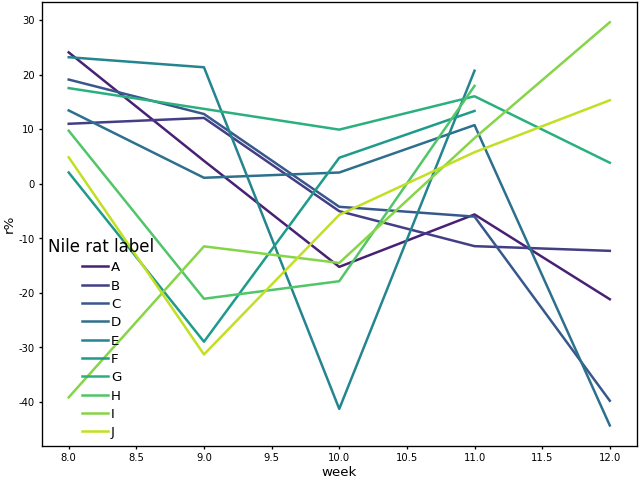

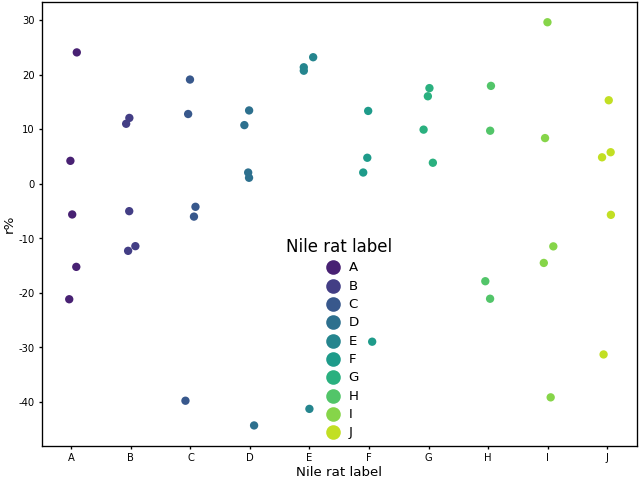

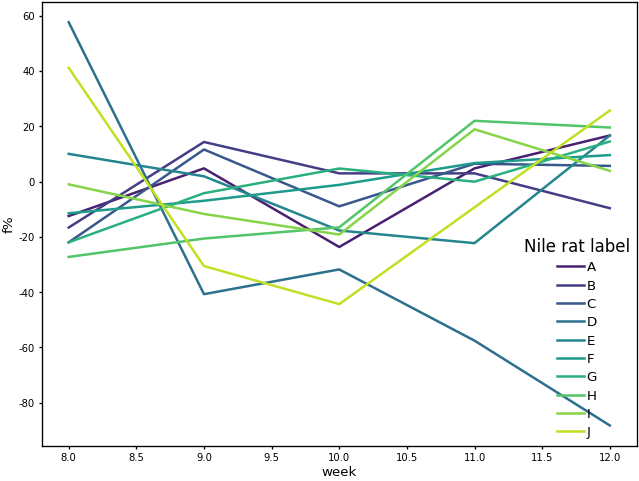

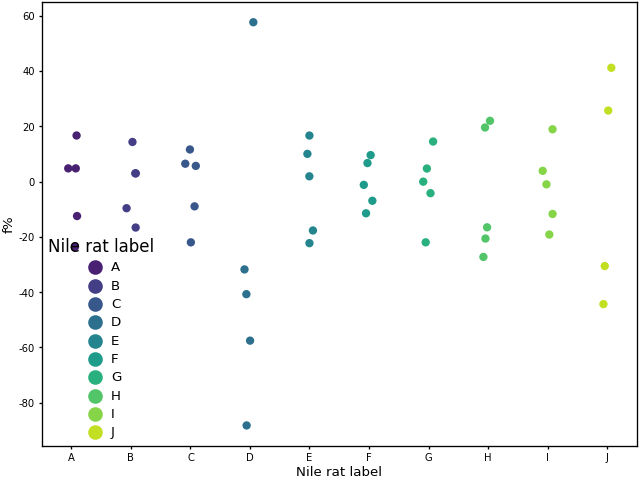

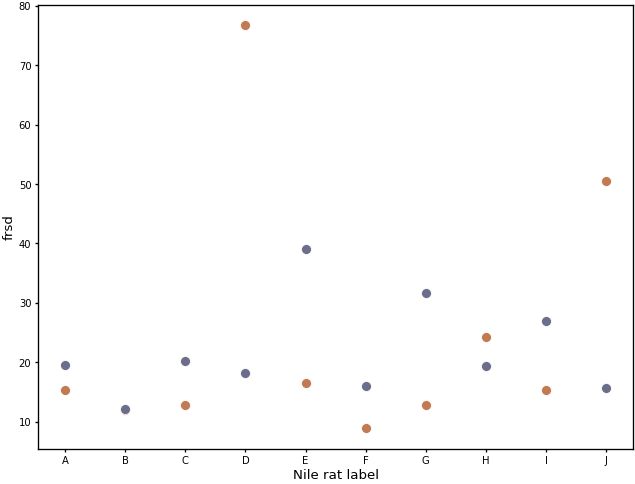

In [298]:
sns.lineplot(data=rdf, x='week', y='r%', hue='Nile rat label', palette=colors, )
plt.figure()
sns.stripplot(data=rdf, x='Nile rat label', y='r%', hue='Nile rat label', dodge=False,  palette=colors,)
plt.figure()
sns.lineplot(data=fdf, x='week', y='f%', hue='Nile rat label', palette=colors, )
plt.figure()
sns.stripplot(data=fdf, x='Nile rat label', y='f%', hue='Nile rat label', dodge=False,  palette=colors,)
plt.figure()
sns.scatterplot(data=bgs, x='Nile rat label', y='frsd', color=colors['FBG'])
sns.scatterplot(data=bgs, x='Nile rat label', y='rrsd', color=colors['RBG'])

# Figure 3 compiled plot (old version)

C:\Users\bjanderson23\anaconda3\lib\site-packages\seaborn\categorical.py:376: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax.set_ylim(-.5, len(self.plot_data) - .5, auto=None)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


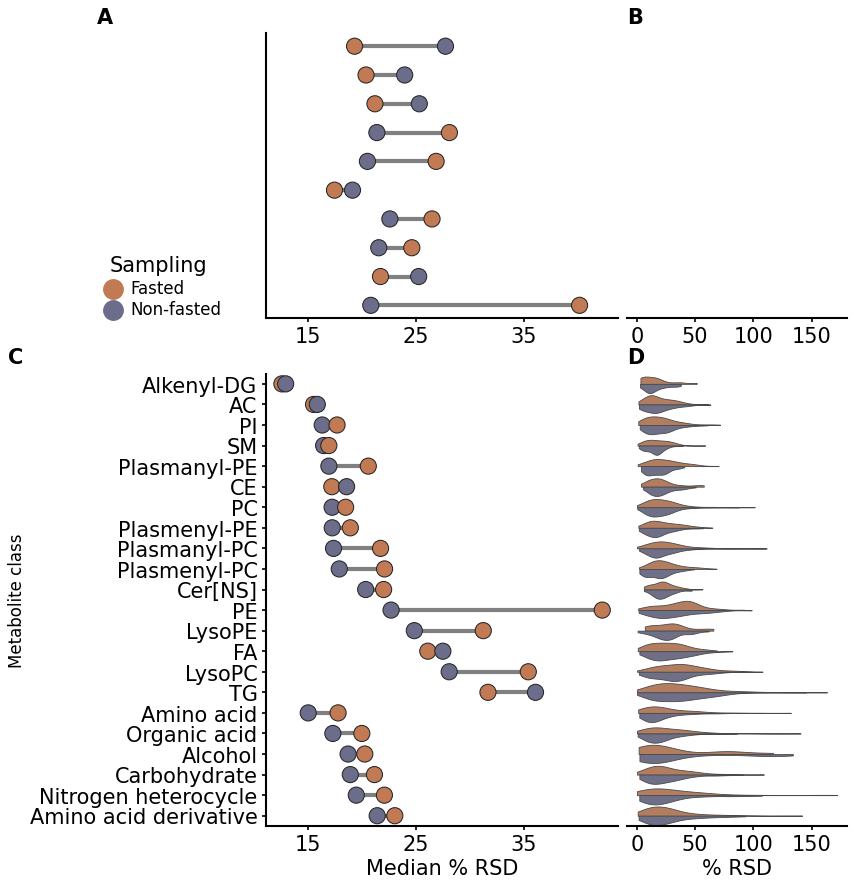

In [15]:
# plt.rcParams['xtick.major.pad'] = 1
# plt.rcParams['ytick.major.pad'] = 1
# plt.rcParams['xtick.major.size'] = 2
# plt.rcParams['ytick.major.size'] = 2
# plt.rcParams['xtick.labelsize'] = 10
# plt.rcParams['ytick.labelsize'] = 7

fig, axs = plt.subplots(
    ncols=2, nrows=2, figsize=(5, 7), dpi=150, sharex='col', sharey='row',
    gridspec_kw={'width_ratios': [1.6,1], 'height_ratios': [0.63,1], 
                 'wspace': 0.03, 'hspace':0.15})

###### B ######
ax = axs[0][1]
sns.violinplot(
    data=violin_data.sort_values('Nile rat label'), 
    x='value', y='Nile rat label', hue='bg_type', split=True, palette=colors, ax=ax,
    orient='h', linewidth=0.7, width=0.8, hue_order=['Non-fasted', 'Fasted'], inner=None,
    cut=0, bw=0.2, legend=False)
ax.set_ylabel(None)
ax.set_xlabel(None)
# ax.legend(loc=(-0.8, 0.4))
ax.tick_params(length=0, axis='y')
ax.tick_params(label1On=True, axis='x')
ax.legend([], [])

###### C ######
ax = axs[1][0]
sns.scatterplot(
    data=per_class,#.loc[per_class['molec_class']],
    x='value', y='molec_class', hue='bg_type', palette=colors, ax=ax,
    s=60, hue_order=['Non-fasted', 'Fasted', ], linewidth=0.5, edgecolor='0.15')
y_loc_dict = {x: i for x, i in zip(per_class['molec_class'].unique(), range(len(per_class['molec_class'].unique())))}
per_class['y_loc'] = per_class['molec_class'].map(y_loc_dict)
for y_loc in range(len(y_loc_dict.values())):
    cls = per_class.loc[per_class['y_loc'] == y_loc, 'value']
    ax.plot([min(cls), max(cls)], [y_loc, y_loc], c='gray', linewidth=2, zorder=-10)
ax.set_xlabel('Median % RSD', fontsize=10)
ax.set_ylabel('Metabolite class')
ax.set_ylim(21.8, -0.8)
ax.set_xticks([15, 25, 35, 45])
handles, labels = ax.get_legend_handles_labels()
ax.legend([], [])

###### D
ax = axs[1][1]
sns.violinplot(
    data=violin_data.loc[violin_data['molec_class'] != 'Unidentified'], 
    x='value', y='molec_class', hue='bg_type', split=True, palette=colors, ax=ax,
    orient='h', linewidth=0.4, width=0.9, order=per_class['molec_class'].unique(), 
    inner=None, cut=0, bw=0.4, legend=False)
# ax.legend(loc=(-0.8, 0.8))
ax.tick_params(length=0, axis='y')
ax.set_ylabel(None)
ax.set_xticks([0, 50, 100, 150])
ax.set_xlabel('% RSD', fontsize=10)
ax.legend([], [])

###### A ######
ax = axs[0][0]
sns.scatterplot(
    data=per_animal, x='% RSD', y='Nile rat label', hue='bg_type', palette=colors, ax=ax,
    s=60, linewidth=0.5, legend=True, edgecolor='0.15')
y_loc_dict = {x: i for x, i in zip('ABCDEFGHIJ', range(10))}
per_animal['y_loc'] = per_animal['Nile rat label'].map(y_loc_dict)
for y_loc in range(len(y_loc_dict.values())):
    cls = per_animal.loc[per_animal['y_loc'] == y_loc, '% RSD']
    ax.plot([min(cls), max(cls)], [y_loc, y_loc], c='gray', linewidth=2, zorder=-10)
ax.tick_params(label1On=True, axis='x')
ax.legend(loc=(-0.48, 0), markerfirst=True, markerscale=1.5, borderpad=0, labelspacing=0.2,
          handletextpad=0, title='Sampling', fontsize=8)

for ax, letter in zip([axs[0][0], axs[0][1], axs[1][0], axs[1][1]], 'ABCD'):
    bb = src.plots.tight_bbox(ax)
    ax.text(x=bb.x0, y=bb.y1+0.01, s=letter, transform=fig.transFigure, fontweight='bold')
    ax.spines[:].set_linewidth(1)

sns.despine(ax=axs[0][0])
sns.despine(ax=axs[1][0])
sns.despine(ax=axs[0][1], left=True)
sns.despine(ax=axs[1][1], left=True)

# plt.savefig('../reports/figures/Figure3/fig3.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('../reports/figures/Figure3/fig3.png', dpi=300, bbox_inches='tight')

## Data exploration of variance and correlation with:
1. FA unsaturations
2. FA carbon length
3. Superclass
4. Mean quant (check for heteroskedasticity) 

True     844
False    565
Name: nonfasted lower RSD, dtype: int64

<AxesSubplot:>

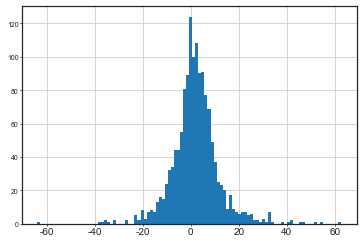

In [241]:
df = (gb
      .groupby(level=['bg_type'])
      .agg('mean')
      .T
      .join(data))
df['diff'] = df['FBG'] - df['RBG']
df['nonfasted lower RSD'] = df['RBG'] < df['FBG']
display(df['nonfasted lower RSD'].value_counts())
df['diff'].hist(bins=100)

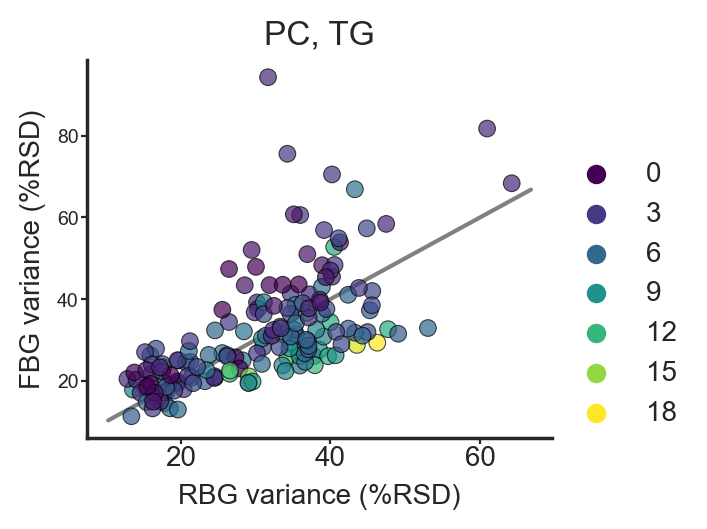

In [249]:
fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)
subdf = df.loc[df['molec_class'].isin(['TG', 'PC'])]
# subdf = df.loc[df['molec_class'] != 'Unidentified'], 
# subdf = df.loc[df['molec_class'].str.contains('PC|PI|PE')],
sns.scatterplot(
    data=subdf,
    x='RBG', y='FBG', 
    hue='fa_unsat', palette='viridis',
#     hue='superclass', palette=colors, 
#     style='molec_class', markers=dict(TG='o', PC='s', FA='^'),
    ax=ax,
    alpha=0.7, linewidth=0.4, edgecolor='black', sizes=100,

)
xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], [xmin, xmax], zorder=-10, color='gray')
ax.set(xlabel='RBG variance (%RSD)', 
       ylabel='FBG variance (%RSD)', 
       title=', '.join(subdf['molec_class'].unique()))
# ax.set_aspect('equal')
ax.legend(loc=(1.01, 0))
fig.set_facecolor('white')
sns.despine()

In [291]:
means = df[data_cols].groupby(axis=1, by=fg['bg_type']).mean().rename({'FBG': 'FBG_mean', 'RBG': 'RBG_mean'}, axis=1)
df = df.join(means)
means

bg_type,FBG_mean,RBG_mean
m_0,18.487555,18.765008
m_1,20.721830,21.654427
m_2,23.298066,22.957654
m_3,24.500973,23.803672
m_4,24.256320,25.154744
...,...,...
l_912,20.107645,20.634844
l_913,18.425069,19.083911
l_914,19.708654,18.289514
l_915,19.775257,18.041009


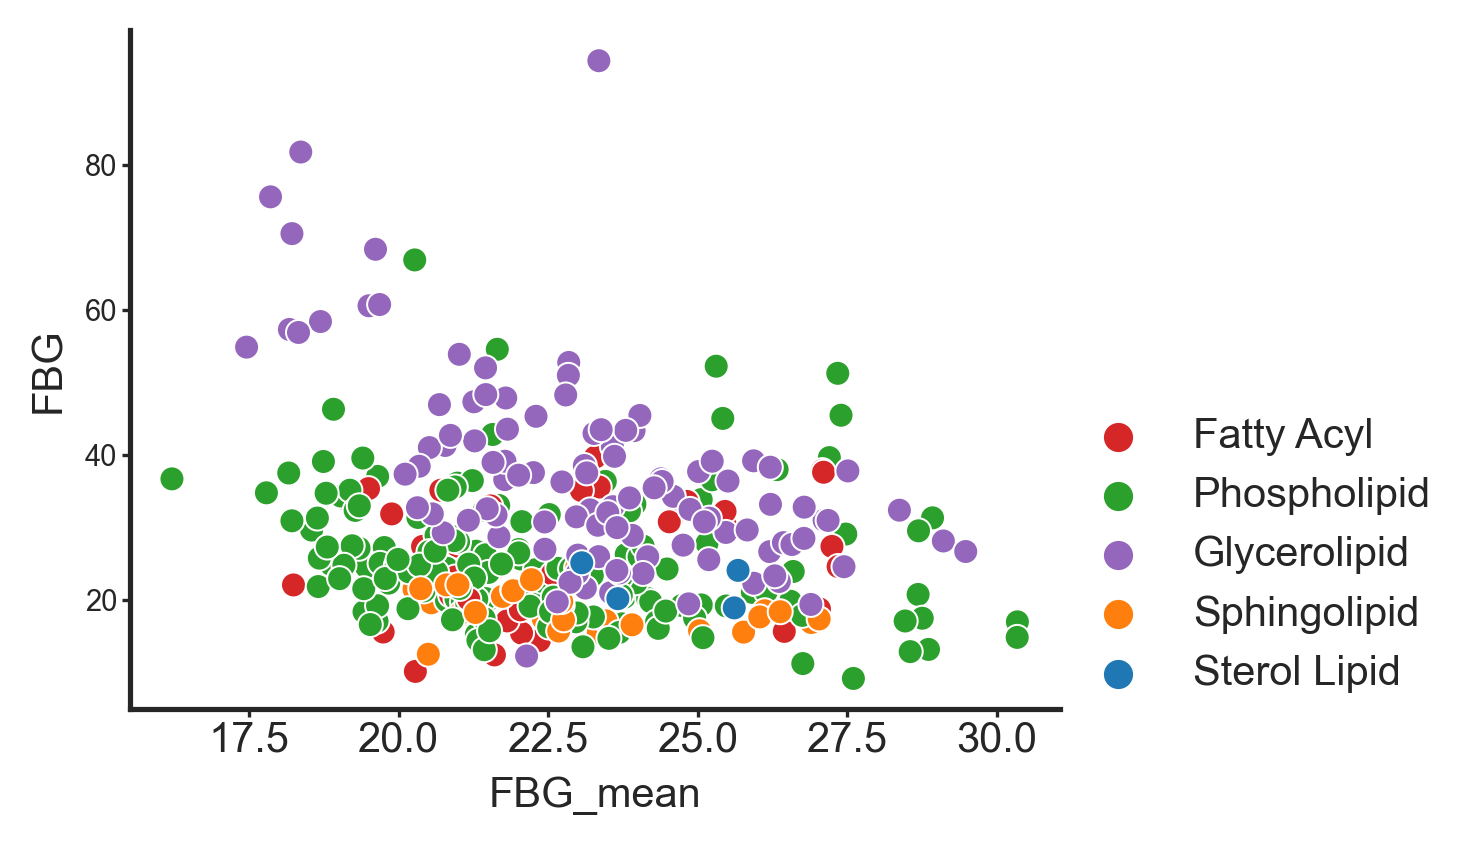

In [295]:
fig, ax = plt.subplots(dpi=300, figsize=(4,3))
sns.scatterplot(
    data=df.loc[(df['ID'] != 'Unidentified') & (df['Type'] == 'lipid')], ax=ax,
    x='FBG_mean', y='FBG', hue='superclass', palette=colors,
    
)
ax.legend(loc=(1, 0))
sns.despine()

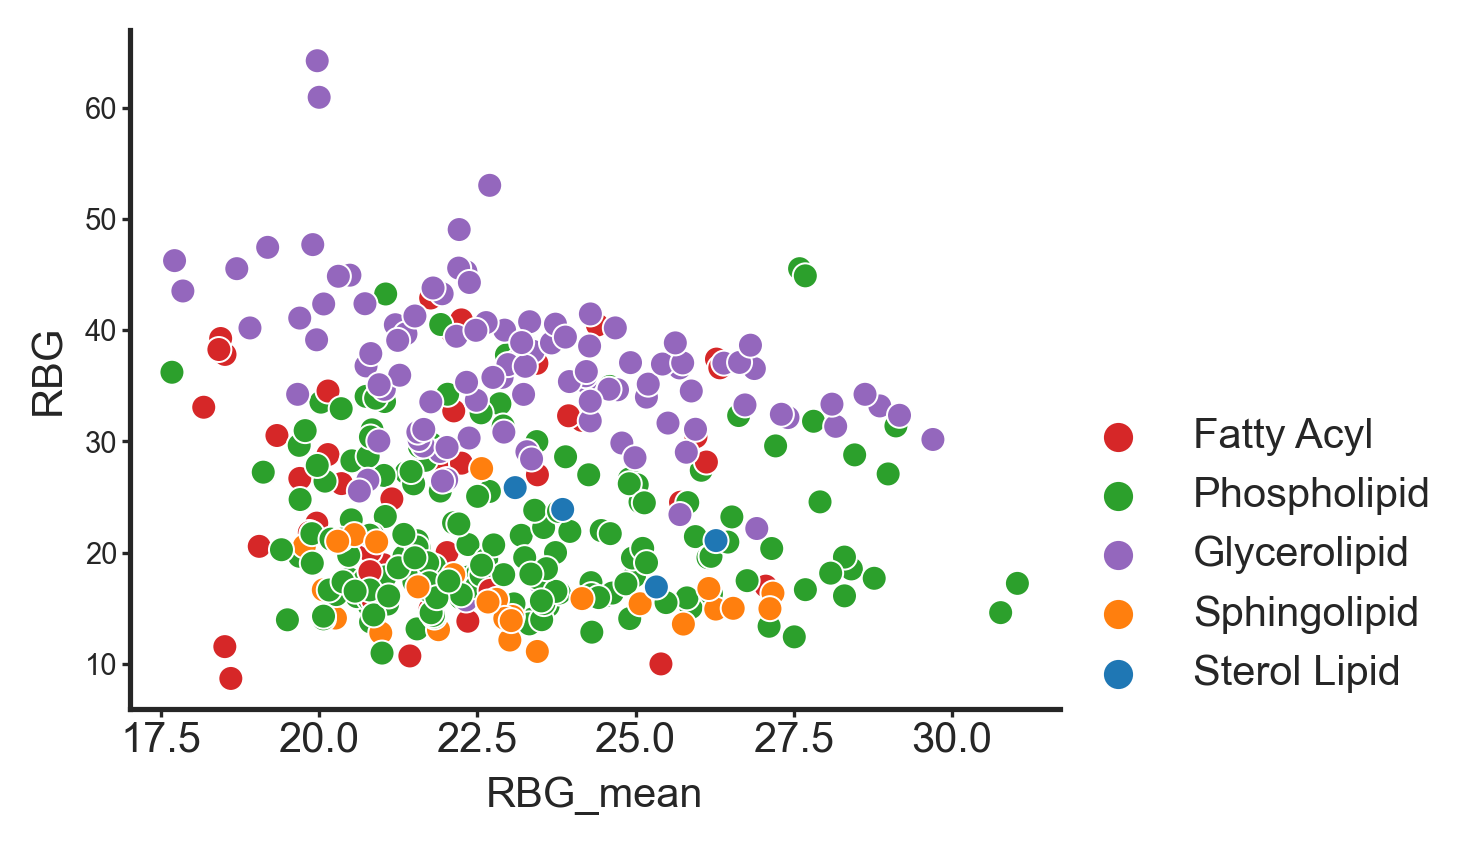

In [297]:
fig, ax = plt.subplots(dpi=300, figsize=(4,3))
sns.scatterplot(
    data=df.loc[(df['ID'] != 'Unidentified') & (df['Type'] == 'lipid')], ax=ax,
    x='RBG_mean', y='RBG', hue='superclass', palette=colors,
    
)
ax.legend(loc=(1, 0))
sns.despine()

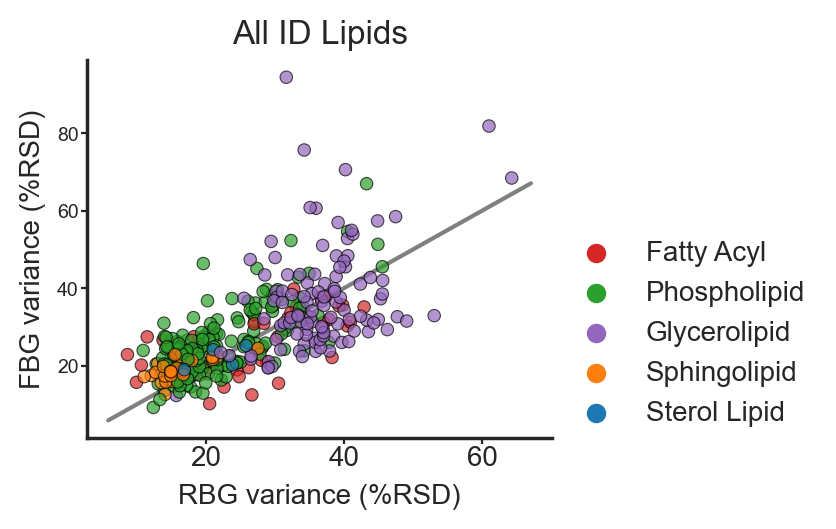

In [279]:
fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)
sns.scatterplot(
#     data=df.loc[df['ID'].str.contains("22:6|20:5|22:5")],
    data=df.loc[(df['ID'] != 'Unidentified') & (df['Type'] == 'lipid')],
    x='RBG', y='FBG', 
    hue='superclass', palette=colors,
    size=
#     hue='superclass', palette=colors, 
#     style='molec_class', markers=dict(TG='o', PC='s', FA='^'),
    ax=ax,
    alpha=0.7, linewidth=0.4, edgecolor='black', s=20,
)
xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], [xmin, xmax], zorder=-10, color='gray')
ax.set(xlabel='RBG variance (%RSD)', 
       ylabel='FBG variance (%RSD)', 
#        title='All lipids with 22:6 or 20:5',
       title='All ID Lipids'
       )
# ax.set_aspect('equal')
ax.legend(loc=(1.01, 0))
fig.set_facecolor('white')
sns.despine()

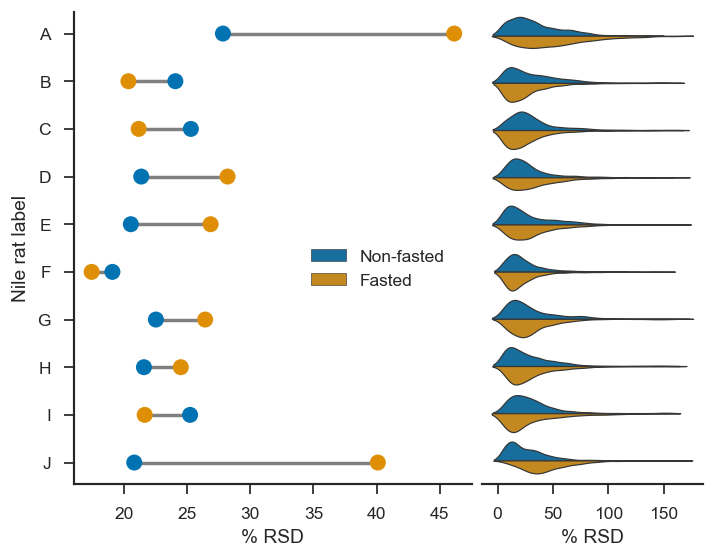

In [382]:
fig, axs = plt.subplots(ncols=2, figsize=(6.5, 5), dpi=125, 
                        gridspec_kw={'width_ratios': [1.8,1], 'wspace': 0.03})
ax = axs[0]
sns.scatterplot(
    data=per_animal,
    x='% RSD', y='Nile rat label', hue='bg_type', palette=colors, ax=ax,
    s=85, linewidth=0, legend=False,
)
y_loc_dict = {x: i for x, i in zip('ABCDEFGHIJ', range(10))}
per_animal['y_loc'] = per_animal['Nile rat label'].map(y_loc_dict)
for y_loc in range(len(y_loc_dict.values())):
    cls = per_animal.loc[per_animal['y_loc'] == y_loc, '% RSD']
    ax.plot([min(cls), max(cls)], [y_loc, y_loc], c='gray', linewidth=2, zorder=-10)
ax = axs[1]
sns.violinplot(
    data=violin_data.sort_values('Nile rat label'), 
    x='value', y='Nile rat label', hue='bg_type', split=True, palette=colors, ax=ax,
    orient='h', linewidth=0.7, width=0.8, hue_order=['Non-fasted', 'Fasted'], inner=None,
    cut=True, bw=0.2,
)
ax.set_xlabel('% RSD')
ax.set_xticks([0, 50, 100, 150])
ax.set_ylabel(None)
ax.set_yticks([])
ax.legend(loc=(-0.8, 0.4))
sns.despine(ax=ax, left=True)
sns.despine(ax=axs[0])

In [458]:
violin_data.loc[violin_data['molec_class'] != 'Unidentified']

,animal,bg_type,i,value,Nile rat label,molec_class
18010,1091,Fasted,l_405,59.491827,A,Plasmanyl-PE
15371,1091,Non-fasted,l_273,29.873659,A,Plasmanyl-PC
15370,1091,Fasted,l_273,38.512256,A,Plasmanyl-PC
25091,1091,Non-fasted,l_759,51.974787,A,TG
25090,1091,Fasted,l_759,102.612530,A,TG
...,...,...,...,...,...,...
11926,1076,Fasted,l_101,38.057468,J,FA
25666,1076,Fasted,l_788,50.116034,J,TG
25667,1076,Non-fasted,l_788,40.073587,J,TG
11927,1076,Non-fasted,l_101,34.736181,J,FA


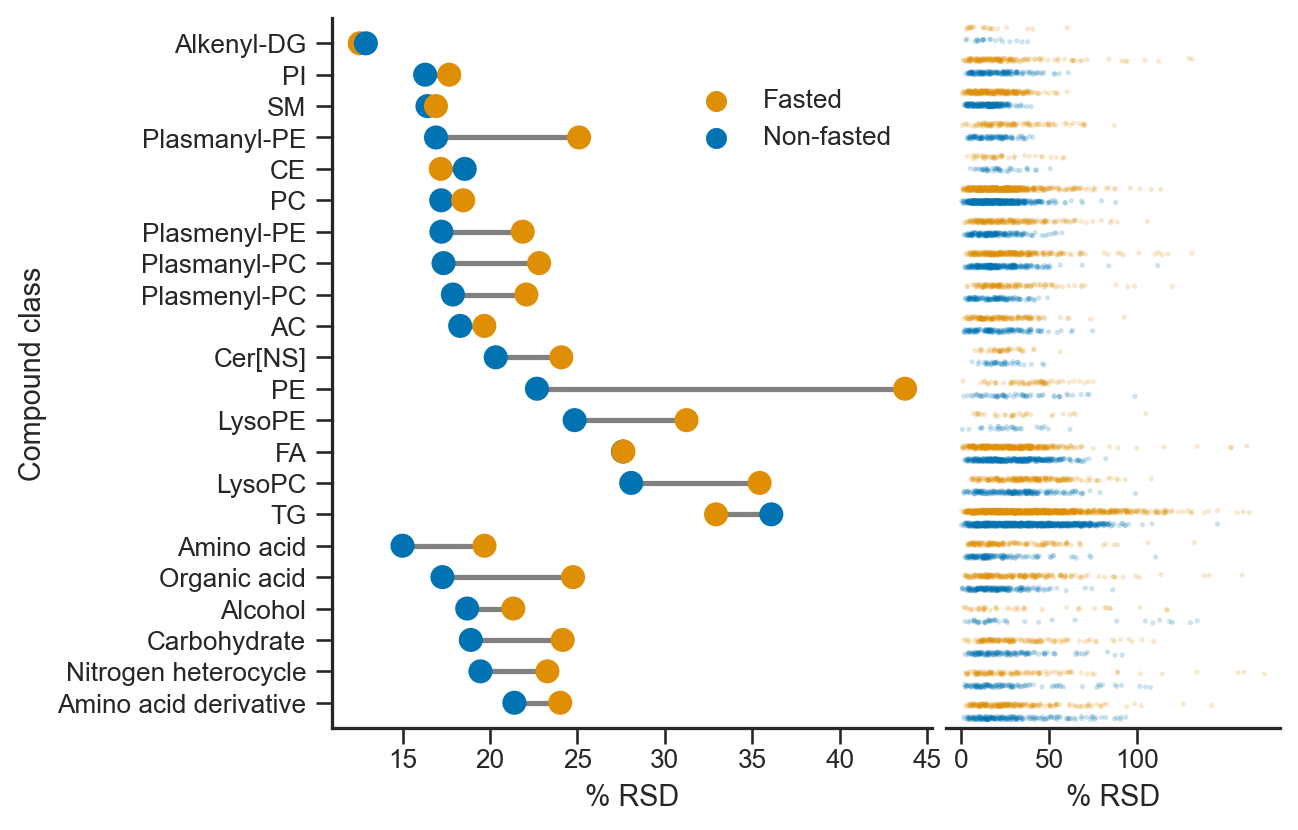

In [457]:
fig, axs = plt.subplots(ncols=2, figsize=(6.5, 5), dpi=188, 
                        gridspec_kw={'width_ratios': [1.8,1], 'wspace': 0.03})
ax = axs[0]
sns.scatterplot(
    data=per_class,#.loc[per_class['molec_class']],
    x='value', y='molec_class', hue='bg_type', palette=colors, ax=ax,
    s=85, hue_order=['Fasted', 'Non-fasted'], linewidth=0,
)
y_loc_dict = {x: i for x, i in 
                zip(per_class['molec_class'].unique(), range(len(per_class['molec_class'].unique())))}
per_class['y_loc'] = per_class['molec_class'].map(y_loc_dict)
for y_loc in range(len(y_loc_dict.values())):
    cls = per_class.loc[per_class['y_loc'] == y_loc, 'value']
    ax.plot([min(cls), max(cls)], [y_loc, y_loc], c='gray', linewidth=2, zorder=-10)
ax.set_xlabel('% RSD')
ax.set_ylabel('Compound class')
# ax.axhspan(-0.7, 15.52, color=colors['lipid'],      label='Lipid',      alpha=0.22, zorder=-20, linewidth=0)
# ax.axhspan(15.5, 21.86, color=colors['metabolite'], label='Polar\nmetabolite', alpha=0.22, zorder=-20, linewidth=0)
ax.set_ylim(21.8, -0.8)
handles, labels = ax.get_legend_handles_labels()
ax.legend(loc=(1.01, 0.5))

ax = axs[1]
# sns.violinplot(
#     data=violin_data.loc[violin_data['molec_class'] != 'Unidentified'], 
#     x='value', y='molec_class', hue='bg_type', split=True, palette=colors, ax=ax,
#     orient='h', linewidth=0.4, width=0.9, order=per_class['molec_class'].unique(), 
#     inner=None, cut=True, bw=0.5,
# )
sns.stripplot(
    data=violin_data.loc[violin_data['molec_class'] != 'Unidentified'], 
    x='value', y='molec_class', hue='bg_type', palette=colors, ax=ax,
    order=per_class['molec_class'].unique(), orient='h', linewidth=0, alpha=0.2, dodge=True, s=2
)

ax.legend(loc=(-0.8, 0.8))
ax.set_yticks([])
ax.set_ylabel(None)
ax.set_xticks([0, 50, 100])
ax.set_xlabel('% RSD')

sns.despine(ax=axs[1], left=True)
sns.despine(ax=axs[0])

# plt.savefig('../reports/figures/RSD_plots/RSD_plot_stripplot.pdf', dpi=150, bbox_inches='tight')

In [ ]:
# sns.stripplot(
#     data=violin_data.loc[violin_data['molec_class'] != 'Unidentified'], 
#     x='value', y='molec_class', hue='bg_type', palette=colors, ax=ax,
#     order=per_class['molec_class'].unique(), orient='h', linewidth=0, alpha=0.2, dodge=True, s=2
# )
# sns.boxplot(
#     data=violin_data.loc[violin_data['molec_class'] != 'Unidentified'], 
#     x='value', y='molec_class', hue='bg_type', palette=colors, ax=ax, width=0.7,
#     order=per_class['molec_class'].unique(), orient='h', linewidth=0.3, showfliers=False,
# )

In [94]:
data_exp2 = data.copy()
data_exp2.loc[:, data_cols] = np.exp2(data_exp2.loc[:, data_cols])

In [95]:
df = data_exp2.loc[:, data_cols].T
# df = data_exp2.loc[data_exp2['Type'] == 'lipid', data_cols].T
df = df.join(fg[['bg_type', 'animal']])
gb = df.groupby(['animal', 'bg_type'], axis=0)
result = gb.std() / gb.mean()
result['mean_rsd'] = result.mean(axis=1) * 100
# result['median'] = result.median(axis=1)
# result.loc[result.index['bg_type'] == 'RBG']
result = result.reset_index()
result = result[['animal', 'bg_type', 'mean_rsd']]
result = result.pivot(index='animal', columns='bg_type', values='mean_rsd')
# result['diff'] = result['RBG'] - result['FBG']
result['rbg_better'] = result['RBG'] < result['FBG']
result['gluc_tol'] = result.index.map(ap['glucose_tolerance'])
# result = result.sort_values(['gluc_tol', 'rbg_better', 'RBG'], ascending=[True, True, True])
result = result.sort_values(['rbg_better', 'RBG'], ascending=[True, True])
result['y_index'] = range(len(result))
result['max_x'] = result[['RBG', 'FBG']].max(axis=1)
result['diff'] = round(result['FBG'] - result['RBG'], 1)
result['diff'] = result['diff'].apply(lambda x: f'+{str(x)}%' if x > 0 else f'‒{str(x)[1:]}%')
# result['y_index'] = range(len(result))

display(result)

vp_result = gb.std() / gb.mean() * 100 
vp_result = vp_result.reset_index()

vp_result = vp_result.melt(id_vars=['animal', 'bg_type'], value_vars=df.columns, value_name='rsd')
vp_result

bg_type,FBG,RBG,rbg_better,gluc_tol,y_index,max_x,diff
animal,,,,,,,
1102,22.902593,23.150130,False,impaired,0,23.150130,‒0.2%
1093,25.521981,31.378172,False,normal,1,31.378172,‒5.9%
1092,27.392891,31.435351,False,impaired,2,31.435351,‒4.0%
1076,45.581143,25.685489,True,diabetic,3,45.581143,+19.9%
1074,34.238233,26.501355,True,impaired,4,34.238233,+7.7%
1101,31.962604,28.085167,True,diabetic,5,31.962604,+3.9%
1062,32.609382,28.187944,True,impaired,6,32.609382,+4.4%
1082,32.495180,30.556074,True,diabetic,7,32.495180,+1.9%
1060,31.979793,31.495319,True,impaired,8,31.979793,+0.5%


,animal,bg_type,variable,rsd
0,1060,FBG,m_0,135.033146
1,1060,RBG,m_0,109.122505
2,1062,FBG,m_0,42.979048
3,1062,RBG,m_0,19.083103
4,1074,FBG,m_0,41.796211
...,...,...,...,...
27415,1093,RBG,l_872,38.184628
27416,1101,FBG,l_872,43.266060
27417,1101,RBG,l_872,34.610618
27418,1102,FBG,l_872,32.240494


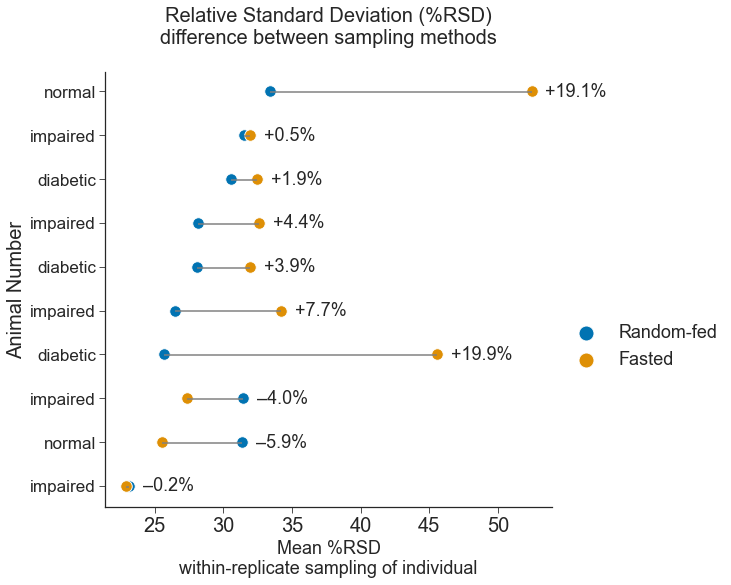

In [107]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)

sns.scatterplot(data=result, x='RBG', y='y_index', 
                color=colors['RBG'], 
                s=133,
#                 size='n', sizes=(55, 400),
                label='Random-fed',
                ax=ax)
sns.scatterplot(data=result, x='FBG', y='y_index', 
                color=colors['FBG'], 
                s=133,
#                 size='n', sizes=(55, 400),
                label='Fasted',
                ax=ax)
plt.hlines(y=result['y_index']-0.02, xmin=result['RBG'], xmax=result['FBG'], color='grey', alpha=1)

# add text of difference between
for i, row in result.iterrows():
    plt.annotate(text=row['diff'],
                 xy=(row['max_x'] + 0.99, row['y_index']), 
                 ha='left', va='center', fontsize=18)
# for i, row in result.iterrows():
#     plt.text(x=-0.2, y=row['y_index'], s='n = '+str(row['n']), fontsize=18, ha='right')
# plt.annotate('Lower is better', xy=(5, 15), fontsize=17, ha='right')  # ← 
# plt.text(s='Lower is better', x=5, y=14, fontsize=18, ha='left')

plt.yticks(ticks=result['y_index'], labels=result['gluc_tol'], fontsize=17);
plt.xticks(fontsize=20)
plt.ylabel('Animal Number', fontsize=20)
plt.xlabel('Mean %RSD\nwithin-replicate sampling of individual', fontsize=18)
plt.title('Relative Standard Deviation (%RSD)\ndifference between sampling methods\n', fontsize=20)

# handles, labels = ax.get_legend_handles_labels()
# handles = [handles[0]] + [handles[6]] + handles[1:6]
# labels = [labels[0]] + [labels[6]] + labels[1:6]
plt.legend(
#     handles=handles, labels=labels,
    loc=(1.02, 0.3), markerscale=1.3, fontsize=18)

sns.despine()
# plt.tight_layout()
# plt.savefig(r',,,.png',
#             facecolor='white',
#             dpi=300,
#             bbox_inches='tight')
# plt.savefig(r',,,.svg',
#             facecolor='white',
#             dpi=300,
#             bbox_inches='tight')

# Violin plot
## back-to-back violin plots, horizontal orientation

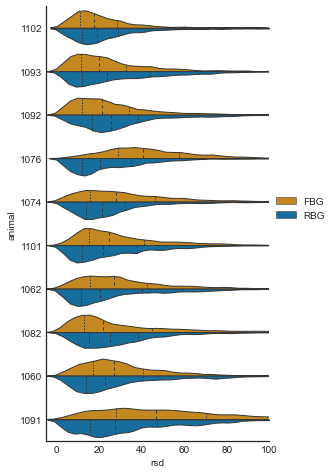

In [97]:
fig, ax = plt.subplots()
fig.set_size_inches(4, 8)

sns.violinplot(
    data=vp_result, x='rsd', y='animal', 
    bw=0.1,
#     cut=1, 
    gridsize=50,
    order=result.index, linewidth=1,
    inner='quart',
    hue='bg_type',
    split=True,
    orient='h',
    palette=colors,
    ax=ax,
)

plt.xlim(-5, 100)
# plt.grid()
plt.legend(loc=(1.01, 0.5))

sns.despine()

# Combine plots

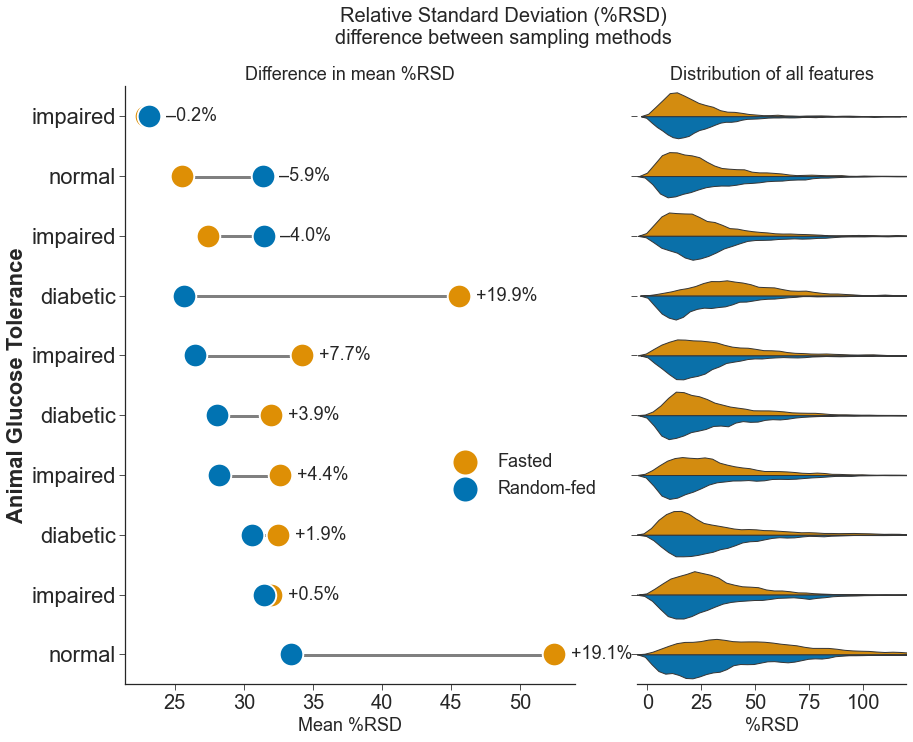

In [108]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, 
                               gridspec_kw={'width_ratios': [2, 1.2], 'wspace': 0.172})
fig.set_size_inches(14, 11)

sns.scatterplot(data=result, x='FBG', y='y_index', 
                color=colors['FBG'], 
                s=555,
#                 size='n', sizes=(55, 400),
                label='Fasted', zorder=3,
                ax=ax1)
sns.scatterplot(data=result, x='RBG', y='y_index', 
                color=colors['RBG'], 
                s=555,
#                 size='n', sizes=(55, 400),
                label='Random-fed', zorder=5,
                ax=ax1)
ax1.hlines(y=result['y_index']+0.01, xmin=result['RBG'], xmax=result['FBG'], 
           color='grey', alpha=1, zorder=0, linewidth=3,)

for i, row in result.iterrows():
    ax1.annotate(text=row['diff'],
                 xy=(row['max_x'] + 1.2, row['y_index']), 
                 ha='left', va='center', fontsize=18)
# ax1.text(s='Lower is better', x=25, y=1, fontsize=18, ha='left')

# handles, labels = ax.get_legend_handles_labels()
# handles = [handles[0]] + [handles[6]] + handles[1:6]
# labels = [labels[0]] + [labels[6]] + labels[1:6]
ax1.legend(
#     handles=handles, labels=labels,
    loc=(0.7, 0.3), markerscale=1.1, fontsize=18)

sns.violinplot(
    data=vp_result, x='rsd', y='animal', 
    bw=0.1, gridsize=50,
    order=result.index, linewidth=1, inner=None,
    hue='bg_type', split=True, orient='h',
    palette=colors, saturation=0.9, legend=False,
    ax=ax2,
)
ax1.set_yticks(ticks=result['y_index'], labels=result['gluc_tol'], fontsize=22)
ax1_xticks = ax1.get_xticks()[1:-1]
ax1.set_xticks(ax1_xticks, ax1_xticks.astype('int'), fontsize=20)
ax1.set_ylabel('Animal Glucose Tolerance', fontsize=22, fontweight='bold')
ax1.set_xlabel('Mean %RSD', fontsize=18)  # \nwithin-replicate sampling of individual
ax1.set_title('Difference in mean %RSD', fontsize=18)

ax2.set_ylabel('')
ax2.set_xlim(-5, 120)
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticks().astype('int'), fontsize=20)
ax2.set_xticks([0, 25, 50, 75, 100], [0, 25, 50, 75, 100], fontsize=20)
ax2.set_xlabel('%RSD', fontsize=18)
ax2.set_title('Distribution of all features', fontsize=18)
ax2.get_legend().remove()

# fig.supxlabel('Calculated on repeated measurement of individual')
fig.suptitle('Relative Standard Deviation (%RSD)\ndifference between sampling methods\n', fontsize=20)
sns.despine(ax=ax1)
sns.despine(ax=ax2, left=True)
plt.savefig(r'../reports/figures/4-4-1/mean_RSD_diff.png',
            facecolor='white',
            dpi=300,
            bbox_inches='tight')
plt.savefig(r'../reports/figures/4-4-1/mean_RSD_diff.svg',
            facecolor='white',
            dpi=300,
            bbox_inches='tight')

## Variance plot for Yunyun's method comparison 

In [94]:
data = pd.read_csv(r'D:/Yunyun_method_dev/data/processed/compound_with class for Ben_20220713.csv', index_col=0)
area_cols = data.filter(regex='Group_Area')

groups = {
    **{col: 'butanol' for col in area_cols.filter(regex='Butanol').columns},
    **{col: 'MAW' for col in area_cols.filter(regex='MAW').columns},
    **{col: 'MM500' for col in area_cols.filter(regex='ModMat500_').columns},
    **{col: 'MM500BB' for col in area_cols.filter(regex='ModMat500BB').columns},
    **{col: 'Original' for col in area_cols.filter(regex='Original').columns},
    **{col: 'QC' for col in area_cols.filter(regex='_QC_')}
}
# groups

In [78]:
df = (data
    .loc[data['Checked'] == True, data.columns.isin(area_cols.columns.to_list() + ['super_class'])]
    .groupby(['super_class'])
    .agg('mean')
    .T
#     .insert(loc=0, column='method', value=area_cols.columns.map(groups))
       )
# df = np.log2(df)
df['method'] = df.index.map(groups)
df = df.melt(value_vars=df.columns[:-1], id_vars='method')
log2 = df.copy()
log2['value'] = np.log2(log2['value'])
df

,method,super_class,value
0,butanol,Acyl carnitines,9.170717e+07
1,butanol,Acyl carnitines,8.742044e+07
2,butanol,Acyl carnitines,4.451356e+07
3,MAW,Acyl carnitines,6.789830e+07
4,MAW,Acyl carnitines,7.815528e+07
...,...,...,...
171,Original,Others,7.682694e+07
172,QC,Others,1.130811e+08
173,QC,Others,1.111685e+08
174,QC,Others,1.044122e+08


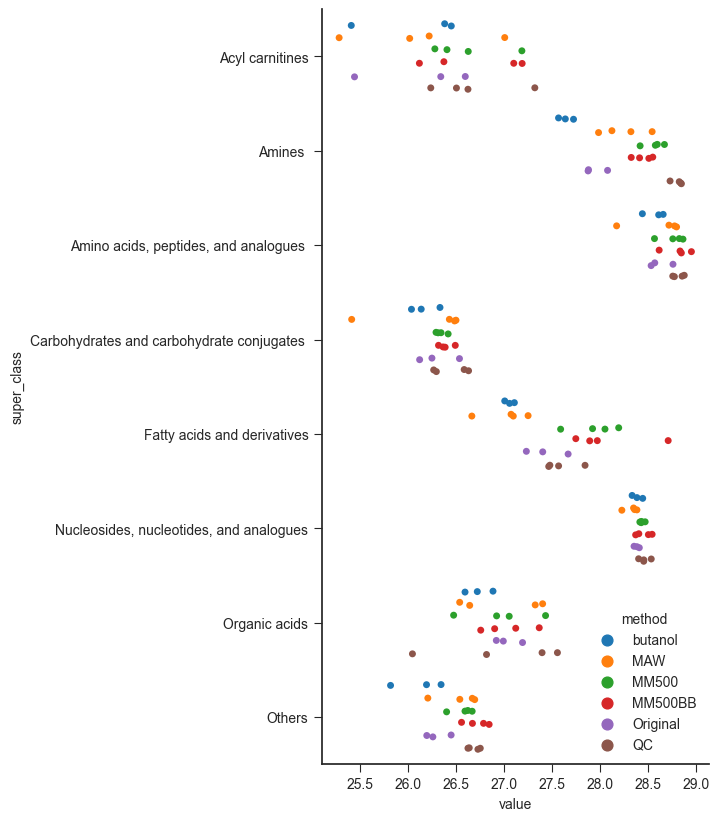

In [80]:
fig, ax = plt.subplots(figsize=(5, 10), dpi=100, facecolor='white')
sns.stripplot(
    data=log2, x='value', y='super_class', hue='method', ax=ax, #orient='h',
    dodge=True, 
#     jitter=False,
)
sns.despine()

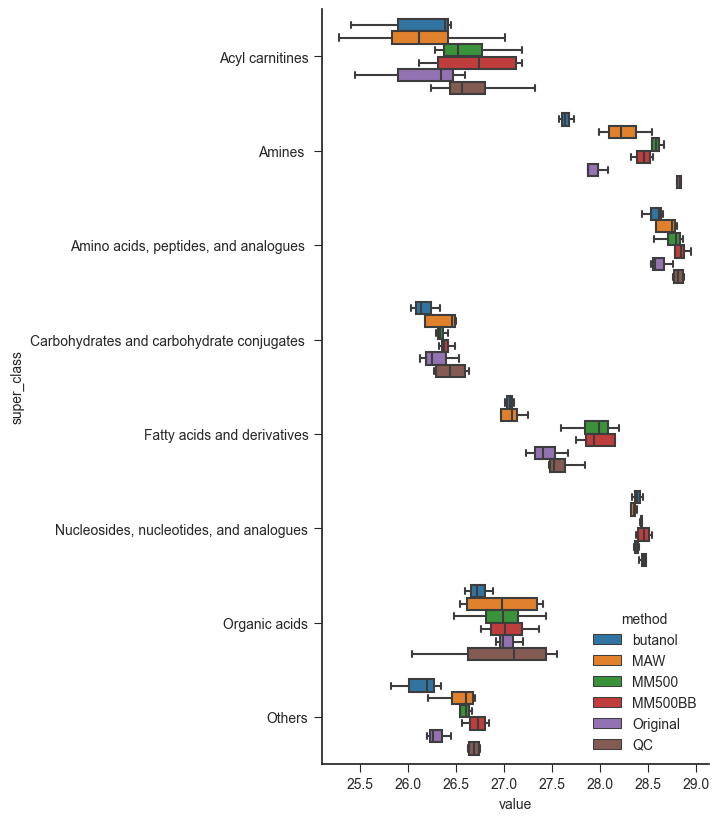

In [72]:
fig, ax = plt.subplots(figsize=(5, 10), dpi=100, facecolor='white')
sns.boxplot(
    data=log2, x='value', y='super_class', hue='method', ax=ax, #orient='h',
    dodge=True, 
#     jitter=False,
    showfliers=False,
)
sns.despine()

In [85]:
rsd = (df
    .groupby(['method', 'super_class'])
    .agg(lambda x: x.mean() / x.std())
    .reset_index()
      )
rsd

,method,super_class,value
0,MAW,Acyl carnitines,2.031097
1,MAW,Amines,5.858556
2,MAW,"Amino acids, peptides, and analogues",5.392148
3,MAW,Carbohydrates and carbohydrate conjugates,3.333620
4,MAW,Fatty acids and derivatives,6.132451
5,MAW,"Nucleosides, nucleotides, and analogues",20.992120
6,MAW,Organic acids,3.285495
7,MAW,Others,6.827756
8,MM500,Acyl carnitines,3.327159
9,MM500,Amines,13.807622


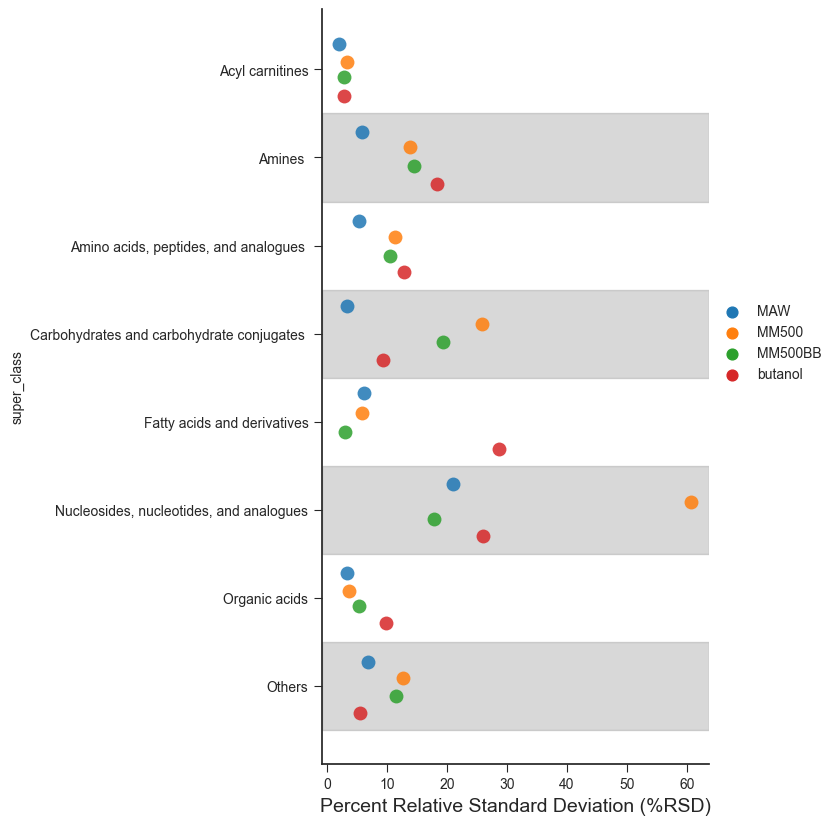

In [92]:
fig, ax = plt.subplots(figsize=(5, 10), dpi=100, facecolor='white')
sns.stripplot(
    data=rsd.loc[~rsd['method'].isin(['Original', 'QC'])], 
    x='value', y='super_class', hue='method', ax=ax,
    dodge=True, size=10, alpha=0.85
)
for i, superclass in enumerate(rsd['super_class'].unique()):
    if i % 2 == 1:
        ax.axhspan(i-0.5, i+0.5, color='gray', alpha=0.3, zorder=-10)
plt.xlabel('Percent Relative Standard Deviation (%RSD)', fontsize=14)
plt.legend(loc=(1.01, 0.5))
sns.despine()

In [3]:
# Standardize data
# data.loc[:, data_cols] = StandardScaler().fit_transform(data.loc[:, data_cols])
# data.loc[:, data_cols]

# Make file grouping 
hmfg = fg[['animal', 'bg_type']].T
# Make another file grouping
hmfg2 = fg[['animal', 'bg_type', 'gluc_tol']].drop_duplicates().set_index(['bg_type', 'animal'])

d = data.loc[:, data_cols].append(hmfg).T
d = d.groupby(['bg_type', 'animal']).mean()
d = d.join(hmfg2)

# Set metadata as indexes
d.set_index('gluc_tol', append=True, inplace=True)
d.sort_values(['bg_type', 'gluc_tol', 'animal'], ascending=[True, False, True], inplace=True)
# d = d.T
d

l_0        l_1        l_2        l_3  \
bg_type animal gluc_tol                                               
FBG     1091   normal    23.670564  24.426323  23.814945  27.047760   
        1093   normal    23.349007  24.616548  23.379382  26.856975   
        1060   impaired  23.449521  24.831670  23.744392  26.953347   
        1062   impaired  23.216855  24.421992  23.356738  26.891357   
        1074   impaired  23.018708  24.185953  23.780521  27.171006   
        1092   impaired  23.101794  24.529641  23.353036  26.837090   
        1102   impaired  23.397215  24.717923  23.763796  26.669624   
        1076   diabetic  22.679690  23.594023  23.103339  26.243724   
        1082   diabetic  23.431994  24.821577  24.038831  27.055425   
        1101   diabetic  23.154617  24.622188  23.729049  26.855539   
RBG     1091   normal    23.966487  24.912942  23.413989  27.350338   
        1093   normal    23.611918  24.567604  23.952991  26.970232   
        1060   impaired  23.840615  25.054730  24.048209  26.942758   
        1062   impaired  23.174288  23.608273  23.749417  27.198735   
        1074   impaired  23.841427  24.962976  24.020401  27.329256   
        1092   impaired  23.792566  24.777115  23.895966  26.998344   
        1102   impaired  23.327583  23.821103  23.528009  26.981334   
        1076   diabetic  23.734863  24.378175  24.449786  27.084315   
        1082   diabetic  23.484084  24.385322  23.706616  27.033307   
        1101   diabetic  23.527161  24.712632  23.719033  27.351148   

                               l_4        l_5        l_6        l_7  \
bg_type animal gluc_tol                                               
FBG     1091   normal    22.170247  26.436732  30.424704  22.466074   
        1093   normal    22.533255  26.449655  29.886286  22.344402   
        1060   impaired  23.045461  26.772249  30.242452  22.307307   
        1062   impaired  22.580229  26.094048  30.027633  22.107637   
        1074   impaired  22.422509  26.311464  30.149799  22.358722   
        1092   impaired  22.474257  26.422284  29.803868  22.168762   
        1102   impaired  22.677837  26.558844  30.213943  21.652245   
        1076   diabetic  21.424737  25.785970  29.826501  21.363046   
        1082   diabetic  22.366938  26.500553  30.194233  22.469145   
        1101   diabetic  22.692777  26.635056  29.893134  22.022698   
RBG     1091   normal    22.522382  26.369622  30.082804  22.245460   
        1093   normal    22.766641  26.289131  29.724295  22.193878   
        1060   impaired  23.111682  26.549709  30.545997  22.049367   
        1062   impaired  22.836285  25.802277  30.074647  22.321493   
        1074   impaired  23.168719  26.720635  30.201864  22.192797   
        1092   impaired  22.327510  26.536968  30.031506  22.095893   
        1102   impaired  22.490114  26.265088  29.628747  22.088169   
        1076   diabetic  23.238189  26.765223  30.220139  22.219264   
        1082   diabetic  22.766074  26.174567  29.874454  21.999458   
        1101   diabetic  22.704753  26.508672  29.912160  22.483285   

                               l_8        l_9  ...      m_682      m_368  \
bg_type animal gluc_tol                        ...                         
FBG     1091   normal    26.377794  24.326876  ...  20.577814  23.013146   
        1093   normal    25.825897  23.655871  ...  20.256022  22.662139   
        1060   impaired  26.009478  23.951241  ...  20.042547  22.365933   
        1062   impaired  25.893946  23.497447  ...  19.709896  22.319930   
        1074   impaired  26.064572  23.761601  ...  20.633094  22.845992   
        1092   impaired  25.718736  23.434220  ...  20.025014  22.484600   
        1102   impaired  26.003035  23.460890  ...  20.249462  22.592770   
        1076   diabetic  25.680440  22.886061  ...  19.429659  22.204800   
        1082   diabetic  26.126511  23.991184  ...  20.208397  22.441951   
        1101   diabetic  25.784276  23.702454  ...  20.014211  22.569

In [4]:
data.loc[data['fdr corrected pval effect of sampling'] < 0.000000000000000001].index

Index(['l_65', 'l_88', 'l_213', 'l_218', 'l_223', 'l_237', 'l_283', 'l_285',
       'l_291', 'l_293', 'l_372', 'l_375', 'l_382', 'l_383', 'l_425', 'l_427',
       'l_430', 'l_431', 'l_462', 'l_648', 'l_649', 'l_657', 'l_669', 'l_680',
       'l_681', 'l_734', 'l_751', 'l_822', 'l_1027', 'm_349', 'm_673', 'm_303',
       'm_9', 'm_519', 'm_460', 'm_70'],
      dtype='object', name='i')

## Perform Wilcoxon signed rank test on the 10 pairs of distributions, put asterisks next to significant pairs

In [12]:
pairs = {animal: {'RBG': None, 'FBG': None} for animal in animals_used}

for bg_type, pos_index, bg_color in zip(['FBG', 'RBG'], [0, 1], [colors['FBG'], colors['RBG']]):
    for animal, position in zip(animals_used, positions):
        files = fg.loc[(fg['animal'] == animal) & (fg['bg_type'] == bg_type)].index
        df = data.loc[:, files]#.mean(axis=1)
        df = (df.std(axis=1)/df.mean(axis=1)) * 100
        pairs[animal][bg_type] = df
        
wilcoxon_test = {}
for animal, dfs in pairs.items():
    rbg = dfs['RBG']
    fbg = dfs['FBG']
    wilcoxon_test[animal] = wilcoxon(rbg, fbg)[1]
wilcoxon_test

{1091: 7.261296575751756e-47,
 1093: 7.429715870297852e-10,
 1060: 0.24527022757086647,
 1062: 7.022679845989094e-17,
 1074: 4.668867845568178e-33,
 1092: 2.4431757335185137e-15,
 1102: 0.6663749502965913,
 1076: 4.4062427014813735e-158,
 1082: 0.00029890243625575,
 1101: 4.3292217738676625e-23}

[(0.0, 1.0), (2.5, 3.5), (5.0, 6.0), (7.5, 8.5), (10.0, 11.0), (12.5, 13.5), (15.0, 16.0), (17.5, 18.5), (20.0, 21.0), (22.5, 23.5)]


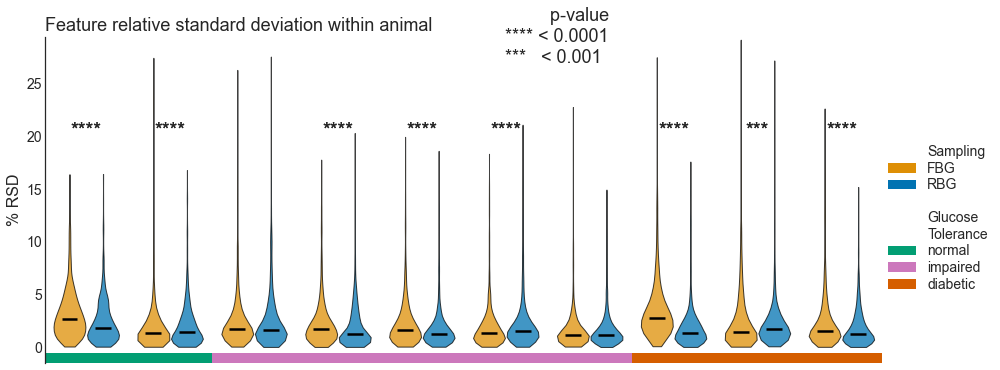

In [37]:
signif_sampling = data.loc[data['fdr corrected pval effect of sampling'] < 2].index

# fig, (ax, axcbar) = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [5, 1]})
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
# plt.xlim(-1, 29)
# plt.ylim(0.0, 0.7)
# positions = [(0,1), (2.5,3.5), (5,6), (7.5,8.5), (10,11), (12.5,13.5), (15,16), (17.5,18.5), (20,21), (22.5,23.5)]
x = (0, 1)
positions = [(x[0] + offset, x[1] + offset) for offset in np.arange(0, 25, 2.5)]
print(positions)
# ax.set_xticks([np.mean(x) for x in positions])
# ax.set_xticklabels([str(animal) + '\n' + animal_gluc_tol[animal] for animal in animals_used], fontsize=16)

for bg_type, pos_index, bg_color in zip(['FBG', 'RBG'], [0, 1], [colors['FBG'], colors['RBG']]):
    for animal, position in zip(animals_used, positions):
        files = fg.loc[(fg['animal'] == animal) & (fg['bg_type'] == bg_type)].index
        df = data.loc[signif_sampling, files]#.mean(axis=1)
        df = (df.std(axis=1)/df.mean(axis=1)) * 100
#         df = df.std(axis=1)/df.mean(axis=1)
        v = plt.violinplot(
            df, 
            positions=[position[pos_index]],
            widths=0.95,
            points=45,
            showmeans=False,
            showextrema=False,
            showmedians=True,
#             quantiles=[0, 0.9],
#             handle=(('Fasted' if bg_type == 'FBG' else 'Random-fed') if animal==1102 else None)
        )
#         for bodies, cmeans, cmaxes, cmins, cbars, cquantiles in v:
        for part in v['bodies']:
            part.set_facecolor(bg_color)
            part.set_edgecolor('black')
            part.set_alpha(0.75)
        animal_color = colors[str(animal)]
        for line in [
#             'cmaxes', 
#             'cbars', 
#             'cmins', 
            'cmedians',
#             'cmeans', 
#             'cquantiles',
             ]:
#             v[line].set_color(animal_color)
            v[line].set_color('black')
            v[line].set_linewidths(2.5)
        # print significance asterisks
        if wilcoxon_test[animal] < 0.0001:
            ax.annotate('****', xy=(position[0]+0.5, 20), fontsize=20, ha='center')
        elif wilcoxon_test[animal] < 0.001:
            ax.annotate('***', xy=(position[0]+0.5, 20), fontsize=20, ha='center')
        elif wilcoxon_test[animal] < 0.01:
            ax.annotate('**', xy=(position[0]+0.5, 20), fontsize=25, ha='center')
        elif wilcoxon_test[animal] < 0.05:
            ax.annotate('*', xy=(position[0]+0.5, 20), fontsize=25, ha='center')
        

keys = list(colors.keys())[2:7]
labels = [name for name in keys]
handles = [Patch(facecolor=colors[label]) for label in labels]
legend_categories = ['Sampling', '\nGlucose\nTolerance']
for divider, category in zip([0, 3], legend_categories): 
    handles.insert(divider, Patch(edgecolor='white', facecolor='white', alpha=0))
    labels.insert(divider, category)
ax.legend(handles, labels, loc=(1, 0.2), fontsize=14, labelspacing=0.2)
# ax.legend(handles, ['Fasted', 'Post-prandial'], loc=(1.01, 0.5), fontsize=15)
ax.annotate('         p-value\n**** < 0.0001 \n***   < 0.001', xy=(12.99, 27), fontsize=18, )


ax.margins(x=0.01, y=0.01)
plt.yticks(fontsize=14)
plt.ylabel('% RSD', fontsize=16)
sns.despine(bottom=True)
ax.set_title('Feature relative standard deviation within animal',#      < 0.0001 ****    < 0.001  ***', 
             fontsize=18, loc='left')
# ax.annorate
plt.xticks([], [])

original_xlim = plt.xlim()
dividers = [(positions[1][1] + positions[2][0])/2, (positions[6][1] + positions[7][0])/2]
plt.axvspan(-100,        dividers[0], ymin=0, ymax=0.03, facecolor=colors['normal'],)
plt.axvspan(dividers[0], dividers[1], ymin=0, ymax=0.03, facecolor=colors['impaired'],)
plt.axvspan(dividers[1], 100,         ymin=0, ymax=0.03, facecolor=colors['diabetic'],)
plt.xlim(original_xlim)
plt.ylim(bottom=-1.5)

plt.savefig(r'..\reports\figures\4-4-1\RvF_RSD_per_rat.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\4-4-1\RvF_RSD_per_rat.png', bbox_inches='tight')

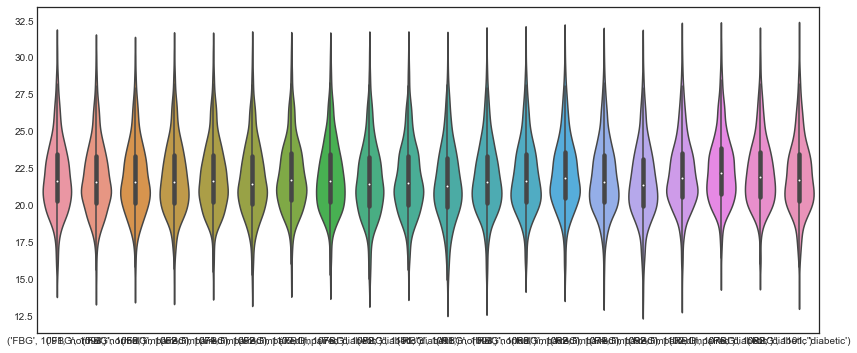

In [10]:
sns.violinplot(data=d.T)

fig = plt.gcf()
fig.set_size_inches((14,6))

In [196]:
for bg_type, pos_index, bg_color in zip(['FBG', 'RBG'], [0, 1], [colors['FBG'], colors['RBG']]):
    for i, (animal, position) in enumerate(zip(animals_used, positions)):
        files = fg.loc[(fg['animal'] == animal) & (fg['bg_type'] == bg_type), 'combined_col_name']
        df = data[files]
        display(df.mean(axis=1)/df.std(axis=1))

i
l_0       43.249393
l_1       18.856541
l_2       57.093581
l_3       75.427518
l_4       29.771018
            ...    
m_169    206.395720
m_213      6.628793
m_24      39.365602
m_505     23.123211
m_441     39.093178
Length: 1727, dtype: float64

i
l_0       72.658342
l_1      110.480202
l_2       72.385376
l_3      106.840731
l_4       30.937176
            ...    
m_169     86.526405
m_213     16.162214
m_24     152.217511
m_505     32.995891
m_441     76.893259
Length: 1727, dtype: float64

i
l_0      132.724216
l_1       41.804300
l_2       57.026350
l_3      105.147759
l_4       54.181066
            ...    
m_169    233.056729
m_213     10.945104
m_24      61.647489
m_505     15.230408
m_441    308.538564
Length: 1727, dtype: float64

i
l_0      153.230007
l_1      152.853347
l_2       65.242174
l_3      121.555784
l_4      113.893948
            ...    
m_169    156.850813
m_213      7.566004
m_24      34.898137
m_505      9.239072
m_441     78.610440
Length: 1727, dtype: float64

i
l_0       29.151818
l_1       14.408948
l_2       66.410721
l_3       58.898398
l_4      135.895823
            ...    
m_169    285.133695
m_213      8.971422
m_24      67.240211
m_505     27.577414
m_441     82.942577
Length: 1727, dtype: float64

i
l_0       41.286390
l_1      129.946832
l_2       46.565178
l_3       32.712137
l_4       46.414428
            ...    
m_169    444.277450
m_213     11.208574
m_24      41.605853
m_505     10.087832
m_441    114.006071
Length: 1727, dtype: float64

i
l_0      115.244131
l_1       85.102590
l_2      246.046557
l_3       76.104449
l_4       72.802138
            ...    
m_169    388.663400
m_213     16.523081
m_24     100.654956
m_505     57.649702
m_441    394.805129
Length: 1727, dtype: float64

i
l_0       11.401856
l_1       11.975119
l_2       10.927934
l_3       16.239688
l_4       11.946358
            ...    
m_169    108.648716
m_213      8.770629
m_24      39.379802
m_505      7.069091
m_441     62.432728
Length: 1727, dtype: float64

i
l_0      151.757207
l_1      209.620600
l_2      256.820933
l_3       77.688854
l_4       45.240340
            ...    
m_169    260.109750
m_213     11.775488
m_24      59.598657
m_505     30.286710
m_441     70.532642
Length: 1727, dtype: float64

i
l_0       33.153305
l_1       74.805498
l_2       80.766211
l_3      107.784112
l_4       60.061386
            ...    
m_169     81.621249
m_213      7.633212
m_24      39.803128
m_505      7.977387
m_441    102.782421
Length: 1727, dtype: float64

i
l_0       71.016891
l_1       33.314304
l_2       16.427123
l_3      989.125528
l_4       21.976604
            ...    
m_169    348.304179
m_213     41.170382
m_24     214.208978
m_505     66.427245
m_441    159.329182
Length: 1727, dtype: float64

i
l_0       30.471409
l_1       35.273934
l_2       77.682163
l_3       37.702654
l_4       41.791372
            ...    
m_169    130.104131
m_213     14.691750
m_24      77.177883
m_505     20.885236
m_441    103.462307
Length: 1727, dtype: float64

i
l_0       34.889069
l_1       39.703885
l_2       27.528672
l_3       31.548779
l_4       28.671377
            ...    
m_169     99.464444
m_213      6.467432
m_24      32.593588
m_505      9.088316
m_441    104.029517
Length: 1727, dtype: float64

i
l_0       32.955849
l_1       19.291759
l_2       54.838319
l_3       97.571622
l_4       43.240101
            ...    
m_169    244.887818
m_213     61.273601
m_24     517.261378
m_505    173.100887
m_441    278.557111
Length: 1727, dtype: float64

i
l_0      122.452665
l_1       79.156169
l_2       43.622106
l_3      221.192874
l_4      115.399633
            ...    
m_169    216.128995
m_213      7.930279
m_24      52.304602
m_505     13.239594
m_441     87.742446
Length: 1727, dtype: float64

i
l_0      155.436570
l_1      134.633546
l_2       62.215988
l_3       59.490710
l_4       29.487881
            ...    
m_169    135.438731
m_213      8.240182
m_24      39.976161
m_505      8.048925
m_441     78.431526
Length: 1727, dtype: float64

i
l_0      229.180064
l_1       17.360256
l_2       77.085594
l_3      101.156898
l_4       34.361264
            ...    
m_169    680.224569
m_213     82.904318
m_24     332.945739
m_505    247.447815
m_441    584.295776
Length: 1727, dtype: float64

i
l_0       69.723981
l_1       43.232924
l_2       83.832582
l_3       54.736336
l_4      101.293809
            ...    
m_169    169.346472
m_213     21.185940
m_24     134.049968
m_505    124.590079
m_441    190.248094
Length: 1727, dtype: float64

i
l_0      131.220325
l_1       39.055490
l_2       23.662213
l_3       36.871800
l_4       30.464412
            ...    
m_169    188.319580
m_213     13.091512
m_24      73.791684
m_505     27.841360
m_441    124.074999
Length: 1727, dtype: float64

i
l_0       56.265075
l_1       82.093668
l_2      119.390881
l_3       52.343033
l_4      142.394321
            ...    
m_169    248.737810
m_213     11.236301
m_24      76.586345
m_505     24.528767
m_441    236.298725
Length: 1727, dtype: float64

KeyError: 'combined_col_name'

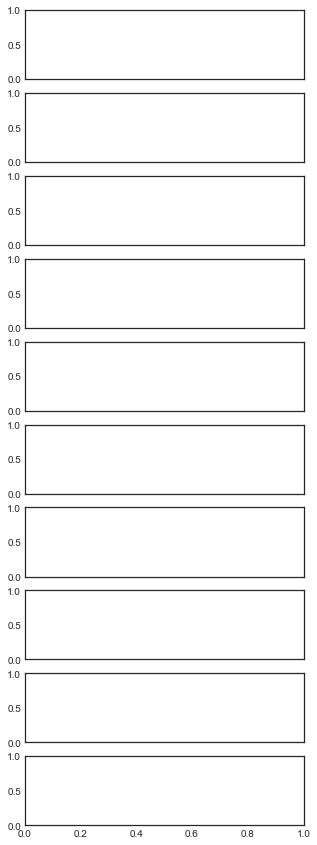

In [7]:
signif_sampling = data.loc[data['fdr corrected pval effect of sampling'] < 0.05].index


fig, axs = plt.subplots(nrows=10, sharex=True, sharey=True)
fig.set_size_inches(5, 15)

for bg_type, pos_index, bg_color in zip(['FBG', 'RBG'], [0, 1], [colors['FBG'], colors['RBG']]):
    for i, (animal, position) in enumerate(zip(animals_used, positions)):
        files = fg.loc[(fg['animal'] == animal) & (fg['bg_type'] == bg_type), 'combined_col_name']
        df = data.loc[signif_sampling, files]#.mean(axis=1)
        df = df.std(axis=1)/df.mean(axis=1)
        ax = axs[i]
        ax.hist(df, bins=40, alpha=0.5, color=bg_color)
        ax.set_yticks([])
        ax.set_xticks([])
sns.despine(left=True, bottom=True)
plt.xlim(0, 0.15)
# plt.tight_layout(pad=1.01)
plt.subplots_adjust(hspace=0.01)

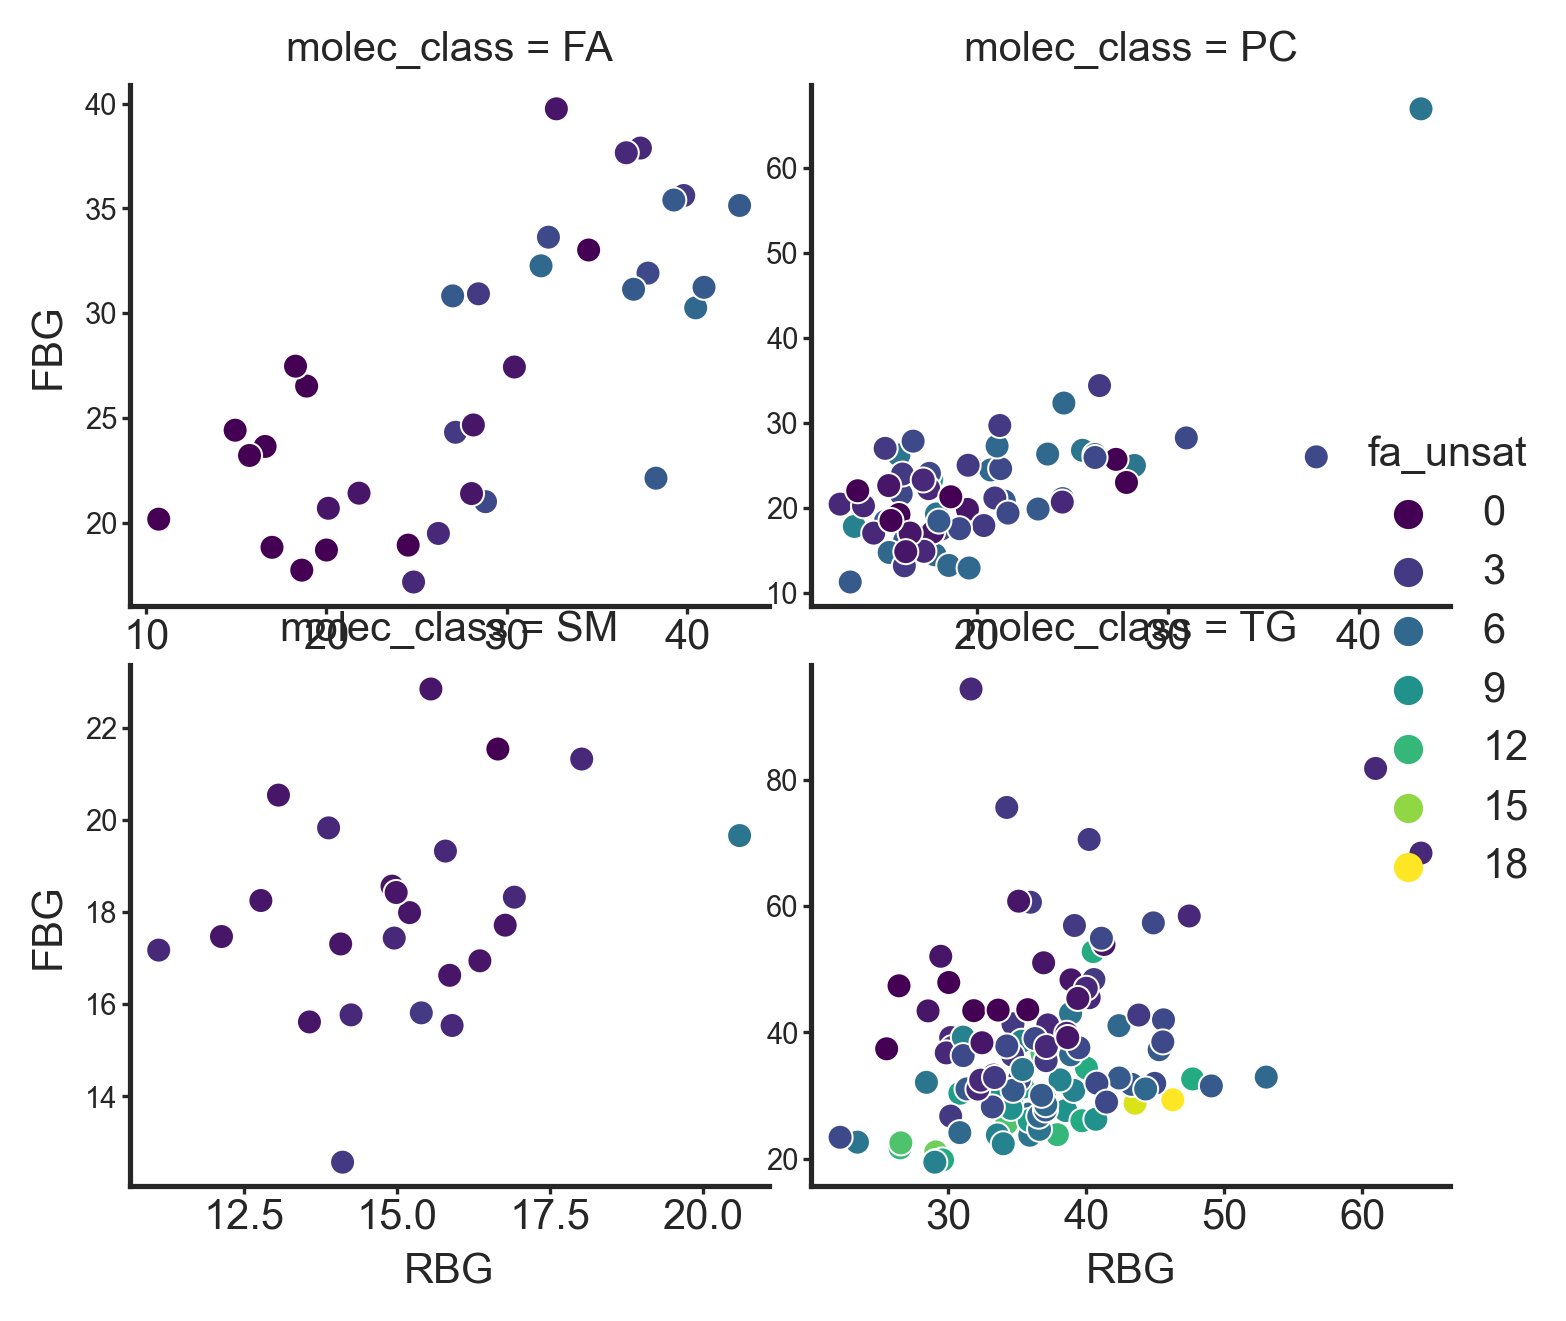

In [135]:
fdf = df.loc[df['molec_class'].isin(['TG', 'PC', 'FA', 'SM'])]
rp = sns.relplot(
    data=fdf, 
    x='RBG', y='FBG', col='molec_class', hue='fa_unsat', palette='viridis',
    col_wrap=2, 
    legend='auto',
    facet_kws=dict(sharex=False, sharey=False, 
#                    gridspec_kws=dict(wspace=0.3, hspace=0.3)
                  ),
)
fig = rp.figure
fig.set_dpi(300)
fig.set_size_inches((5, 4))